# HT including meridional divergence

In [2]:
# # Compute monthly ASC along contour and save

import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob,os
import cmocean.cm as cmocean
import os
import sys

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
logging.getLogger('distributed.utils_perf').setLevel(logging.ERROR)

from dask.distributed import Client



In [3]:
client = Client(n_workers=112)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 112
Total threads: 112,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42439,Workers: 112
Dashboard: /proxy/8787/status,Total threads: 112
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:44423,Total threads: 1
Dashboard: /proxy/36585/status,Memory: 2.23 GiB
Nanny: tcp://127.0.0.1:44467,


In [4]:
	year='2095'
	monthdays = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
	month = '1'
	month = month.zfill(2)
	#year = str(sys.argv[2])
	start_time=year+'-'+month  
	 #Start_time0 and end_time0 are for importing the daily transport, and it ahsthe number of days in the month    
	start_time0=year+'-'+month +'-01'     
	end_time0=year+'-'+month +'-' + str(monthdays[np.int(np.int(month)-1)])
	print(start_time0) 
	print(end_time0) 
	exp = '01deg_jra55v13_ryf9091'
	
	print("Start date =" + start_time) 
	year2=str(np.int(start_time[0:4])+1)
	month2=str(np.int(start_time[5:7])+1)
	month2=str(int(month2))
	month2 = month2.zfill(2)    
	print("month2 is =" + month2) 
	print("year2 is =" + str(year2))     
	
	imon = np.int(month)
	if imon <12:
	    end_time=year+'-'+month2
	else:
	    end_time=year2+'-01'
	    
	print("End date =" + end_time) 
	
	 

2095-01-01
2095-01-31
Start date =2095-01
month2 is =02
year2 is =2096
End date =2095-02


In [5]:
	session = cc.database.create_session()
	time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))
	
	# reference density value:
	rho_0 = 1035.0
	# specific heat capacity of sea water:
	cp = 3992.1
	lat_range = slice(-90,-59)
	
	isobath_depth = 1000
	
	# pick a freezing point temp:
	temp_freezing = -3.82
	
	
	print("importing isobath mask")
	outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
	data = np.load(outfile)
	mask_y_transport = data['mask_y_transport']
	mask_x_transport = data['mask_x_transport']
	mask_y_transport_numbered = data['mask_y_transport_numbered']
	mask_x_transport_numbered = data['mask_x_transport_numbered']
	
	yt_ocean = cc.querying.getvar(exp,'yt_ocean',session,n=1)
	yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
	yu_ocean = cc.querying.getvar(exp,'yu_ocean',session,n=1)
	yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
	xt_ocean = cc.querying.getvar(exp,'xt_ocean',session,n=1)
	xu_ocean = cc.querying.getvar(exp,'xu_ocean',session,n=1)   
	
	mask_x_transport =xr.DataArray(data['mask_x_transport']).assign_coords({"dim_0": np.array(yt_ocean),"dim_1": np.array(xu_ocean)}).rename(dim_0="yt_ocean",dim_1="xu_ocean")
	mask_y_transport =xr.DataArray(data['mask_y_transport']).assign_coords({"dim_0": np.array(yt_ocean),"dim_1": np.array(xu_ocean)}).rename(dim_0="yu_ocean",dim_1="xt_ocean")
	mask_x_transport_numbered =xr.DataArray(data['mask_x_transport_numbered']).assign_coords({"dim_0": np.array(yt_ocean),"dim_1": np.array(xt_ocean)}).rename(dim_0="yt_ocean",dim_1="xt_ocean")
	mask_y_transport_numbered =xr.DataArray(data['mask_y_transport_numbered']).assign_coords({"dim_0": np.array(yt_ocean),"dim_1": np.array(xt_ocean)}).rename(dim_0="yt_ocean",dim_1="xt_ocean")
	
	num_points = int(np.maximum(np.max(mask_y_transport_numbered),np.max(mask_x_transport_numbered)))
	    
	lat_along_contour = np.zeros((num_points))
	lon_along_contour = np.zeros((num_points))
	
	# locations for zonal transport:
	x_indices_masked = mask_x_transport_numbered.stack().values
	x_indices = np.sort(x_indices_masked[x_indices_masked>0])
	for count in x_indices:
	    count = int(count)
	    jj = int(np.where(mask_x_transport_numbered==count)[0])
	    ii = int(np.where(mask_x_transport_numbered==count)[1])   
	    lon_along_contour[count-1] = xu_ocean[ii].values
	    lat_along_contour[count-1] = mask_x_transport_numbered.yt_ocean[jj].values
	    
	# locations for meridional transport:
	y_indices_masked = mask_y_transport_numbered.stack().values
	y_indices = np.sort(y_indices_masked[y_indices_masked>0])
	for count in y_indices:
	    count = int(count)
	    jj = np.where(mask_y_transport_numbered==count)[0]
	    ii = np.where(mask_y_transport_numbered==count)[1]
	    lon_along_contour[count-1] = mask_x_transport_numbered.xt_ocean[ii].values
	    lat_along_contour[count-1] = yu_ocean[jj].values
	
	# Note temp_yflux_adv is also positioned on north centre edge of t-cell.
	
	print("importing temp_yflux")
	temp_yflux = cc.querying.getvar(exp,'temp_yflux_adv',session,start_time=start_time, end_time=end_time)
	temp_xflux = cc.querying.getvar(exp,'temp_xflux_adv',session,start_time=start_time, end_time=end_time)
	
	# select latitude range:
	temp_yflux = temp_yflux.sel(yu_ocean=lat_range).sel(time=slice(start_time,end_time)).sel(time=start_time)
	temp_xflux = temp_xflux.sel(yt_ocean=lat_range).sel(time=slice(start_time,end_time)).sel(time=start_time)
	
	temp_yflux = temp_yflux.sum('st_ocean')
	temp_xflux = temp_xflux.sum('st_ocean')
	
	temp_yflux = temp_yflux.load()
	temp_xflux = temp_xflux.load()
	
	print("Saving uhrho_vhrho")
	# save a long term average of vhrho_nt and uhrho_et:
	outpath = '/g/data/x77/wf4500/ASC_project/uhrho_vhrho_'+start_time+'.nc'
	# check if already exists:
	if os.path.exists(outpath):
	    average_transports = xr.open_dataset(outpath)
	    # extract arrays from dataset:
	    uhrho_et = average_transports.uhrho_et
	    vhrho_nt = average_transports.vhrho_nt
	else:
	    vhrho_nt = cc.querying.getvar(exp,'vhrho_nt',session,start_time=start_time, end_time=end_time)
	    uhrho_et = cc.querying.getvar(exp,'uhrho_et',session,start_time=start_time, end_time=end_time)
	#    vhrho_nt = cc.querying.getvar(exp,'vhrho_nt',session,frequency='1 daily')
	#    uhrho_et = cc.querying.getvar(exp,'uhrho_et',session,frequency='1 daily')
	
	    vhrho_nt = vhrho_nt.sel(yt_ocean=lat_range).sel(time=slice(start_time0,end_time0))
	    uhrho_et = uhrho_et.sel(yt_ocean=lat_range).sel(time=slice(start_time0,end_time0))
	
	    vhrho_nttime=vhrho_nt.time
	    vhrho_nt = vhrho_nt.mean('time')
	    uhrho_et = uhrho_et.mean('time')
	    
	    
	    outpath = '/g/data/x77/wf4500/ASC_project/model_data/access-om2/'+exp+'/Antarctic_cross_slope/Monthly/uhrho_vhrho_'+start_time+'.nc'
	    ds = xr.Dataset({'vhrho_nt': vhrho_nt,'uhrho_et':uhrho_et})
	    ds.to_netcdf(outpath)
	    ds.close()
	print('time being calculated is ...')      
	print(vhrho_nttime)
	import os
	outpath = '/g/data/x77/wf4500/ASC_project/model_data/access-om2/'+exp+'/Antarctic_cross_slope/Monthly/uhrho_vhrho_'+start_time+'.nc'
	ds = xr.open_dataset(outpath)
	vhrho_nt = ds['vhrho_nt']
	uhrho_et = ds['uhrho_et']
	
	# subtract freezing point heat transport:
	yt_ocean = cc.querying.getvar('01deg_jra55v13_ryf9091','yt_ocean',session,n=1)
	dxu = cc.querying.getvar('01deg_jra55v13_ryf9091','dxu',session,n=1)
	dyt = cc.querying.getvar(exp,'dyt',session,n=1)
	# give dxu and dyt correct coordinates:
	dxu.coords['nj'] = yt_ocean.values
	dxu.coords['ni'] = xt_ocean['xt_ocean'].values
	dxu = dxu.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
	dyt.coords['nj'] = yt_ocean.values
	dyt.coords['ni'] = xt_ocean['xt_ocean'].values
	dyt = dyt.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
	# select latitude range:
	dxu = dxu.sel(yt_ocean=lat_range)
	dyt = dyt.sel(yt_ocean=lat_range)
	
	# Note that in newer mom5 versions this could also be done with ty_trans_int_z, 
	# but there is a problem with this diagnostic in older runs, and even
	# using ty_trans, there is a slight difference. Not sure why?
	
	# Note vhrho_nt is v*dz*1035 and is positioned on north centre edge of t-cell.
	# sum in depth:
	vhrho_nt = vhrho_nt.sum('st_ocean')
	uhrho_et = uhrho_et.sum('st_ocean')
	# convert to transport:
	vhrho_nt = vhrho_nt*dxu/rho_0
	uhrho_et = uhrho_et*dyt/rho_0
	
	# overwrite coords, so we can add the freezing point (with uhrho_et and vhrho_nt) without problems:
	yu_ocean = cc.querying.getvar(exp,'yu_ocean',session,n=1)
	yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
	vhrho_nt.coords['yt_ocean'] = yu_ocean.values
	vhrho_nt = vhrho_nt.rename(({'yt_ocean':'yu_ocean'}))
	uhrho_et.coords['xt_ocean'] = xu_ocean.values
	uhrho_et = uhrho_et.rename(({'xt_ocean':'xu_ocean'}))
	
	freezing_point_heat_trans_zonal = cp*rho_0*uhrho_et*temp_freezing
	freezing_point_heat_trans_meridional = cp*rho_0*vhrho_nt*temp_freezing
	
	print("Removing freezing point heat transport")
	# compare both ways:
	temp_yflux = temp_yflux - freezing_point_heat_trans_meridional
	temp_xflux = temp_xflux - freezing_point_heat_trans_zonal
	    
	temp_yflux_with_mask = np.multiply(np.array(temp_yflux),np.array(mask_y_transport))
	temp_xflux_with_mask = np.multiply(np.array(temp_xflux),np.array(mask_x_transport))
	
	temp_yflux_with_mask = temp_yflux_with_mask[0]
	temp_xflux_with_mask =temp_xflux_with_mask[0]
	
	# multiply by mask to get correct direction into or out of isobath contour:
	heat_trans_across_contour = np.zeros((num_points))
	
	# locations for zonal transport, already calculated indices above:
	for count in x_indices:
	    count = int(count)
	    jj = int(np.where(mask_x_transport_numbered==count)[0])
	    ii = int(np.where(mask_x_transport_numbered==count)[1])
	    heat_trans_across_contour[count-1] += temp_xflux_with_mask[jj,ii]
	    
	# locations for meridional transport, already calculated indices above:
	for count in y_indices:
	    count = int(count)
	    jj = int(np.where(mask_y_transport_numbered==count)[0])
	    ii = int(np.where(mask_y_transport_numbered==count)[1])
	    heat_trans_across_contour[count-1] += temp_yflux_with_mask[jj,ii]
	
	temp_xflux=temp_xflux[0]
	temp_yflux=temp_yflux[0]

importing isobath mask
importing temp_yflux
Saving uhrho_vhrho
time being calculated is ...
<xarray.DataArray 'time' (time: 31)>
array([cftime.DatetimeNoLeap(2095, 1, 1, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2095, 1, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2095, 1, 3, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2095, 1, 4, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2095, 1, 5, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2095, 1, 6, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2095, 1, 7, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2095, 1, 8, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2095, 1, 9, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2095, 1, 10, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2095, 1, 11, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2095, 1, 12, 12

From here on I need to change the code. I need to make it identify the meridional sections of the coast, and for those sections calculate the meridional convergence.

#### Tentative of new binning that respects meridional sections of Antarctic coast

I will need to bin along distances for that, instead of along longitudes. So first step is to calcualte the distances along the contour

In [6]:
#we  will need distance along the contour
import geopy.distance

distance_along_contour=np.ones(num_points)
for n in range(num_points-1):
    coords_1 = (lat_along_contour[n], lon_along_contour[n])
    coords_2 = (lat_along_contour[n+1], lon_along_contour[n+1])
    distance_along_contour[n+1]=geopy.distance.geodesic(coords_1, coords_2).km

    
# #for the last casE CORNER
# coords_1 = (lat_along_contour[-1], lon_along_contour[-1])
# coords_2 = (lat_along_contour[0], lon_along_contour[0])
distance_along_contour[0]=0

distance_along_contour=np.cumsum(distance_along_contour)

I decided I willc reate a new contour, that respects lon and lat changes. Blue regions will be binned by Lon. red regions will be binned by lat.


In [7]:
	#Recreating the previous lon_binned coordinate for comparisson
	# convert to longitude coordinate and average into 3 degree longitude bins:
	# in degrees:
	bin_width = 3
	bin_spacing = 0.25
	lon_west = -280
	lon_east = 80
	#new Parameters for meridional binning
	    
	# new coordinate and midpoints of longitude bins:
	full_lon_coord = np.arange(lon_west,lon_east+0.25,0.25)
	lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)
	n_bin_edges = len(full_lon_coord)
	np.shape(full_lon_coord)

(1441,)

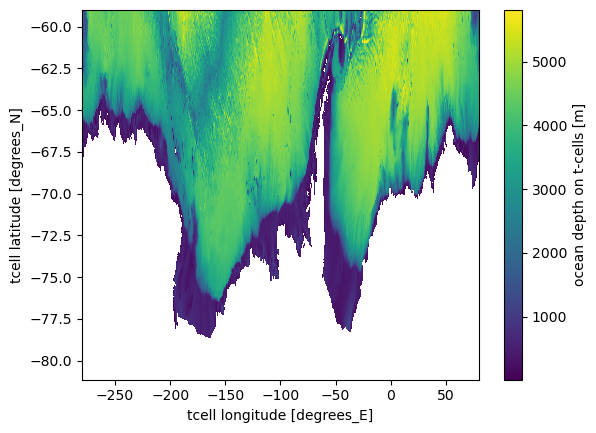

In [8]:
ht = cc.querying.getvar(exp,'ht',session,n=1).sel(yt_ocean=lat_range)
ht.plot()    

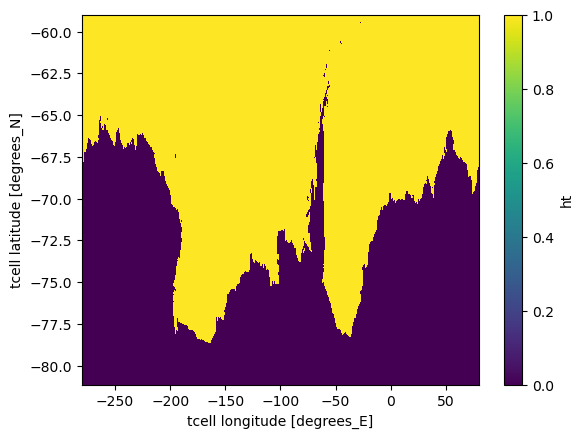

In [9]:
#land and ocean mask for plot
lmask=ht.notnull().astype('int')
lmask.plot()

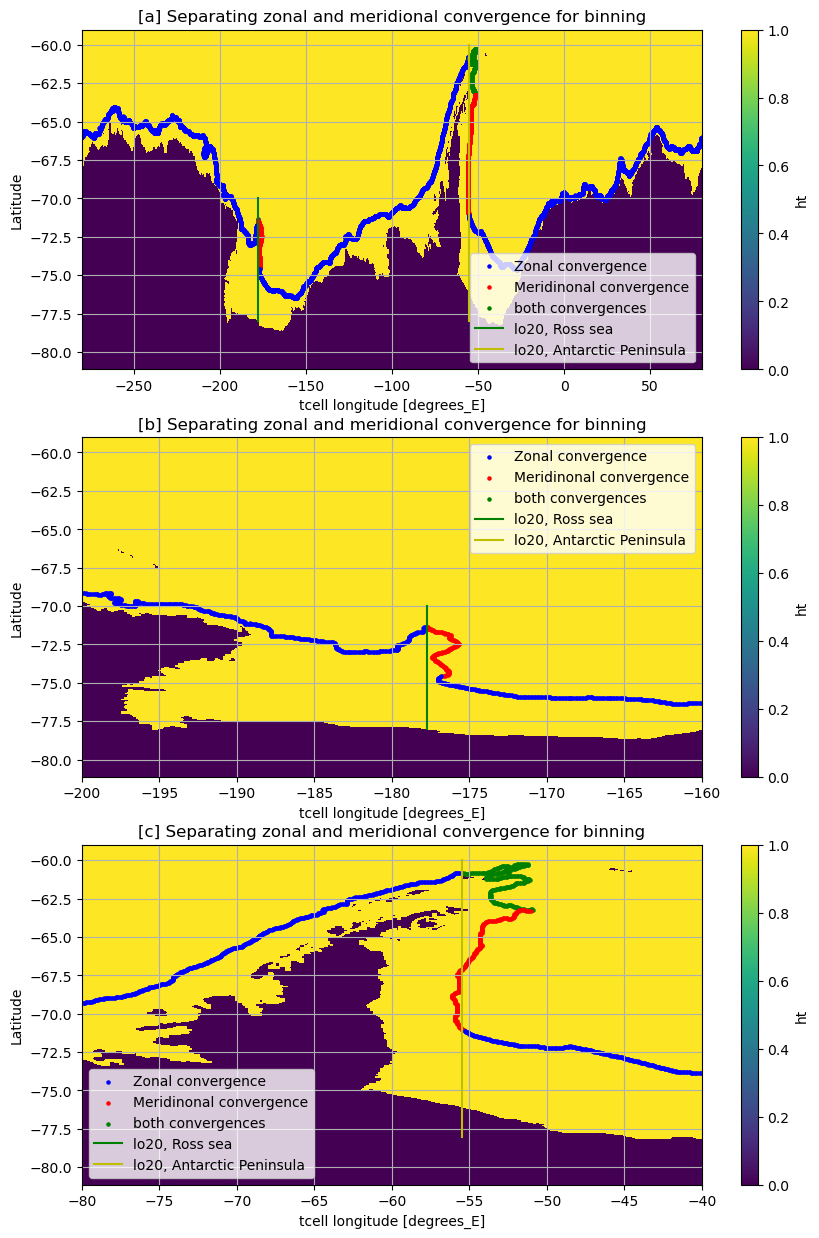

In [10]:
#figure defining the binning
fig = plt.figure(figsize=(10,15))

West_lims=[-280,-200,-80]
East_lims=[80,-160,-40]
nlabels=['[a]','[b]','[c]']
for n in range(3):
    plt.subplot(3,1,n+1)
    lmask.plot(zorder=0)
    #reference point for the meridional heat convergence (lo20 on board)
    S1_ilim=1669;R_lo20=lon_along_contour[S1_ilim]
    S2_ilim=1800
    S3_ilim=3494; A_lo20=lon_along_contour[S3_ilim]
    S35_ilim=3748; 
    S4_ilim=4000

    plt.scatter(lon_along_contour[:S1_ilim],lat_along_contour[:S1_ilim],c='blue',s=5,label='Zonal convergence')# 1st section: bin by lon
    plt.scatter(lon_along_contour[S1_ilim+1:S2_ilim],lat_along_contour[S1_ilim+1:S2_ilim],c='red',s=5,label='Meridinonal convergence')# 2nd section: bin by lat
    plt.scatter(lon_along_contour[S2_ilim+1:S3_ilim],lat_along_contour[S2_ilim+1:S3_ilim],c='blue',s=5)# 1st section: bin by lon
    plt.scatter(lon_along_contour[S3_ilim+1:S35_ilim],lat_along_contour[S3_ilim+1:S35_ilim],c='green',s=5,label='both convergences')

    plt.scatter(lon_along_contour[S35_ilim+1:S4_ilim],lat_along_contour[S35_ilim+1:S4_ilim],c='red',s=5) # 2nd section: bin by lat
    plt.scatter(lon_along_contour[S4_ilim+1:],lat_along_contour[S4_ilim+1:],c='blue',s=5)# 1st section: bin by lon

    plt.plot([R_lo20,R_lo20],[-78,-70],'g',label='lo20, Ross sea')
    plt.plot([A_lo20,A_lo20],[-78,-60],'y',label='lo20, Antarctic Peninsula')    

    plt.grid();plt.legend(); plt.ylabel('Latitude')
    plt.title(nlabels[n]+' Separating zonal and meridional convergence for binning')
    plt.xlim([West_lims[n],East_lims[n]])
    




One issue to be aware of is how we will deal with the heat transport convergence on the edge between the longitudinal and latitudinal bins. On the east of the Antarctic peninsula, in the topmost part of it (~-60S,-51W, drawing below), the northern edge of the first meridional convergence bin will have some heat crossing out of the edge, toward the North. Meanwhile the the western edge of the westernmos zonal bin will have some heat crossing out of the bin towards the west. This heat that is leaving both these cells will be converging yet in the shelf tho, so it needs to be accounted for the closure of the heat budget on the shelf.

In [11]:
#         1000m isobath                   ↙  Cross Slope heat transport
#---------------------------------------↙ 
#  .........................↓..........  !
#    westernmost   :  ignored         :  ! 
#    zonal bin     →  Convergence     ←  !
#  ................: .......↑..........  ! 1000m isobath         
#                 /|                     !
#                / |                     !
#               /  |                     !
#              /   |  Top meridional bin !
#             /    |                     !
#            /     | ..................  !
#           /     /                      !
#          / A.P. \_                     !
#         /         \                    !

# New binning and convergence calculations

This will have points varying along longitude and latitude, therefore will have zonal and meridional binning

Getting the edges for each binning section

In [12]:
#Section 1 edges, zonal binning
S1_first_lon=lon_along_contour[0];S1_last_lon=lon_along_contour[S1_ilim]
S1_first_lat=lat_along_contour[0];S1_last_lat=lat_along_contour[S1_ilim]

#Section 2 edges, meridional binning
S2_first_lon=lon_along_contour[S1_ilim+1];S2_last_lon=lon_along_contour[S2_ilim]
S2_first_lat=lat_along_contour[S1_ilim+1];S2_last_lat=lat_along_contour[S2_ilim]

#Section 3 edges, zonal binning
S3_first_lon=lon_along_contour[S2_ilim+1];S3_last_lon=lon_along_contour[S3_ilim]
S3_first_lat=lat_along_contour[S2_ilim+1];S3_last_lat=lat_along_contour[S3_ilim]

#Section 35 edges, double binning
S35_first_lon=lon_along_contour[S3_ilim+1];S35_last_lon=lon_along_contour[S35_ilim]
S35_first_lat=lat_along_contour[S3_ilim+1];S35_last_lat=lat_along_contour[S35_ilim]

#Section 4 edges, zonal binning
S4_first_lon=lon_along_contour[S35_ilim+1];S4_last_lon=lon_along_contour[S4_ilim]
S4_first_lat=lat_along_contour[S35_ilim+1];S4_last_lat=lat_along_contour[S4_ilim]

#Section 5 edges, meridional binning
S5_first_lon=lon_along_contour[S4_ilim+1];S5_last_lon=lon_along_contour[-1]
S5_first_lat=lat_along_contour[S4_ilim+1];S5_last_lat=lat_along_contour[-1]

Setting the spacing for zonal and meridional building

In [13]:
	#Parameters in zonal binning
	# in degrees:
	lon_bin_width = 3
	lon_bin_spacing = 0.25
	lon_west = -280
	lon_east = 80
	#new Parameters for meridional binning
	lat_bin_width = 3
	lat_bin_spacing = 0.25
	lat_north = np.nanmax(lat_along_contour)+bin_spacing
	lat_south = np.nanmin(lat_along_contour)-bin_spacing
	

#### Section 1 binning (zonal)

In [14]:
	#Section 1, zonal binning
	S1_lon_coord = np.arange(S1_first_lon,S1_last_lon+lon_bin_spacing,lon_bin_spacing)   
	S1_lon_bin_midpoints = np.arange(S1_first_lon+lon_bin_width/2,S1_last_lon-lon_bin_width/2,lon_bin_spacing)
	S1_n_bin_edges = len(S1_lon_coord)
	# sum into longitude bins:
	# need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
	# on the isobath contour and sum continously along contour between defined indices.
	# (i.e. lon_along_contour is not monotonic)
	# find points on contour to define edges of longitude bins:
	bin_edge_indices = np.zeros(S1_n_bin_edges)
	for lon_bin in range(S1_n_bin_edges-1):
	    # find first isobath point that has the right longitude:
	    first_point = np.where(lon_along_contour>=S1_lon_coord[lon_bin])[0][0]
	    # then find all other isobath points with the same longitude as that first point:
	    same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
	    # we want the most southerly of these points on the same longitude line:
	    bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points])]
	    
	# define east/west edges:
	bin_edge_indices = bin_edge_indices.astype(int)
	bin_edge_indices_west = bin_edge_indices[:-int(lon_bin_width/lon_bin_spacing)-1]
	bin_edge_indices_east = bin_edge_indices[int(lon_bin_width/lon_bin_spacing):-1]
	n_bins = len(bin_edge_indices_west)
	
	# sum heat transport from isobath coord into new longitude coord:
	S1_cross_slope_heat_trans = np.zeros(n_bins)
	for lon_bin in range(n_bins):
	    S1_heat_trans_this_bin = heat_trans_across_contour[bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
	    S1_cross_slope_heat_trans[lon_bin] = np.sum(S1_heat_trans_this_bin)
	    
	# find average latitude of each bin, so we can plot back on the isobath:
	S1_lat_bin_midpoints = np.zeros(n_bins)
	for lon_bin in range(n_bins):
	    # find nearest isobath point:
	    S1_lon_index = np.where(lon_along_contour>=S1_lon_bin_midpoints[lon_bin])[0][0]
	    S1_lat_bin_midpoints[lon_bin] = lat_along_contour[S1_lon_index]
	
	

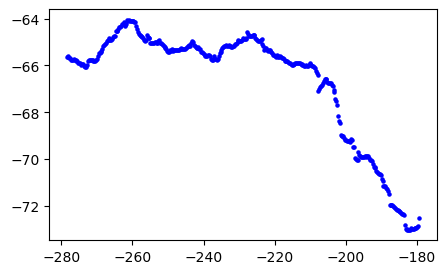

In [15]:
fig = plt.figure(figsize=(5,3))
plt.scatter(S1_lon_bin_midpoints,S1_lat_bin_midpoints,c='blue',s=5,label='Zonal convergence')

In [16]:
	print('Calculating Zonal heat convergence for S1')
	# Need to make sure the zonal boundaries here match exactly with the zonal boundaries used for the 
	# longitude averaging above, by using same bin_edge_indices.
	# Just check if isobath point is on x or y grid. if x, sum up to this point from south.
	# if on y grid, sum zonal transport on nearest u grid point to west.
	
	zonal_heat_trans_west = np.zeros(n_bins)
	for lon_bin in range(n_bins):
	    # west limit:
	    # reset these to False:
	    on_x_grid = False
	    on_y_grid = False
	    # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
	    isobath_west_index = int(bin_edge_indices_west[lon_bin]+1)
	    # check if the point is on the x or y transport grid:
	    if len(np.where(mask_x_transport_numbered==isobath_west_index)[0])>0:
	        on_x_grid = True
	        jj = int(np.where(mask_x_transport_numbered==isobath_west_index)[0])
	        ii = int(np.where(mask_x_transport_numbered==isobath_west_index)[1])
	    elif len(np.where(mask_y_transport_numbered==isobath_west_index)[0])>0:
	        on_y_grid = True
	        jj = int(np.where(mask_y_transport_numbered==isobath_west_index)[0])
	        ii = int(np.where(mask_y_transport_numbered==isobath_west_index)[1])
	    if on_x_grid == True:
	        zonal_heat_trans_west[lon_bin] = np.sum(temp_xflux[:jj,ii]) 
	    # in this case we want transport half a grid point to the west:
	    elif on_y_grid == True:
	        # careful if ii=0, then we need heat trans from lon=80, because at limit of zonal grid
	        if ii==0:
	            zonal_heat_trans_west[lon_bin] = np.sum(temp_xflux[:jj+1,-1])
	        else:
	            zonal_heat_trans_west[lon_bin] = np.sum(temp_xflux[:jj+1,ii-1])
	
	zonal_heat_trans_east = np.zeros(n_bins)
	for lon_bin in range(n_bins):
	    # east limit:
	    # reset these to False:
	    on_x_grid = False
	    on_y_grid = False
	    # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
	    isobath_east_index = int(bin_edge_indices_east[lon_bin]+1)
	    # check if the point is on the x or y transport grid:
	    if len(np.where(mask_x_transport_numbered==isobath_east_index)[0])>0:
	        on_x_grid = True
	        jj = int(np.where(mask_x_transport_numbered==isobath_east_index)[0])
	        ii = int(np.where(mask_x_transport_numbered==isobath_east_index)[1])
	    elif len(np.where(mask_y_transport_numbered==isobath_east_index)[0])>0:
	        on_y_grid = True
	        jj = int(np.where(mask_y_transport_numbered==isobath_east_index)[0])
	        ii = int(np.where(mask_y_transport_numbered==isobath_east_index)[1])
	    if on_x_grid == True:
	        zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux[:jj,ii])
	    # in this case we want transport half a grid point to the west:
	    elif on_y_grid == True:
	        # wrap around to east side of grid:
	        if ii==0:
	            zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux[:jj+1,-1])
	        else:
	            zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux[:jj+1,ii-1])
	
	zonal_convergence = zonal_heat_trans_east - zonal_heat_trans_west

Calculating Zonal heat convergence for S1


In [17]:
S1_zonal_convergence = zonal_convergence
del zonal_convergence

In [18]:
#for reference
np.shape(S1_lon_coord),np.shape(S1_lon_bin_midpoints),np.shape(S1_zonal_convergence)

((410,), (397,), (397,))

It seems like section 1 was binned correctly, by looking at the contour. 

#### Section 2 binning (meridional)

In [19]:
	#Section 2, meridional binning, leading coordinate is latitude
	S2_lat_coord = np.arange(S2_first_lat,S2_last_lat-lat_bin_spacing,-lat_bin_spacing)   
	S2_lat_bin_midpoints = np.arange(S2_first_lat-lat_bin_width/2,S2_last_lat+lat_bin_width/2,-lat_bin_spacing)
	S2_n_bin_edges = len(S2_lat_coord)
	print( "Midpoints are: " +str(S2_lat_bin_midpoints) + '\n\nLatitudes are' + str(S2_lat_coord))


Midpoints are: [-72.89358017]

Latitudes are[-71.39358017 -71.64358017 -71.89358017 -72.14358017 -72.39358017
 -72.64358017 -72.89358017 -73.14358017 -73.39358017 -73.64358017
 -73.89358017 -74.14358017 -74.39358017 -74.64358017]


Notice that for this section we only one midpoint. That is because the extension of this small peninsula is of about 3 degrees, and therefore it matches our latitudinal bin width. Nevertheless I will use this 1 midpoint binning

In [20]:
	bin_edge_indices = np.zeros(S2_n_bin_edges)
	for lat_bin in range(S2_n_bin_edges-1):
	    # Direction of latitude change along the contour is different (go towards negative values instead of positive ones)
	    #Notice because lat goes north and south randomly, we have to constrain the where to the location of work
	    first_point = np.where(lat_along_contour[S1_ilim+1:S2_ilim]<=S2_lat_coord[lat_bin])[0][0]+S1_ilim+1
	    #print('FP='+str(first_point)+'\n\n')        
	    # then find all other isobath points with the same latitude as that first point:
	    same_lat_points = np.where(lat_along_contour[S1_ilim+1:S2_ilim]==lat_along_contour[first_point])[0]+S1_ilim+1
	    #print('FP='+str(first_point)+'\nSLatP='+str(same_lat_points)+'\n\n')
	    # we want the most easternmost of these points on the same latitude line:
	    bin_edge_indices[lat_bin] = same_lat_points[np.argmax(lon_along_contour[same_lat_points])]
	    #print('bin_edge_indices='+str(bin_edge_indices)+'\n\n')
	    
	# define north/south edges:
	bin_edge_indices = bin_edge_indices.astype(int)
	bin_edge_indices_north = bin_edge_indices[:-int(lat_bin_width/lat_bin_spacing)-1]
	print('bin_edge_indices_north='+str(bin_edge_indices_north)+'\n\n')
	bin_edge_indices_south = bin_edge_indices[int(lat_bin_width/lat_bin_spacing):-1]
	print('bin_edge_indices_south='+str(bin_edge_indices_south)+'\n\n')
	n_bins = len(bin_edge_indices_north)
	print('n_bins='+str(n_bins))
	    
	# sum heat transport from isobath coord into new longitude coord:
	S2_cross_slope_heat_trans = np.zeros(n_bins)
	for lat_bin in range(n_bins):
	    S2_heat_trans_this_bin = heat_trans_across_contour[bin_edge_indices_north[lat_bin]:bin_edge_indices_south[lat_bin]]
	    S2_cross_slope_heat_trans[lat_bin] = np.sum(S2_heat_trans_this_bin)
	    
	# find average longitude of each bin, so we can plot back on the isobath:
	S2_lon_bin_midpoints = np.zeros(n_bins)
	for lat_bin in range(n_bins):
	    # find nearest isobath point:
	    S2_lat_index = np.where(lat_along_contour[S1_ilim+1:S2_ilim]<=S2_lat_bin_midpoints[lat_bin])[0][0]+S1_ilim+1
	    S2_lon_bin_midpoints[lat_bin] = lon_along_contour[S2_lat_index]
	
	

bin_edge_indices_north=[1670]


bin_edge_indices_south=[1792]


n_bins=1


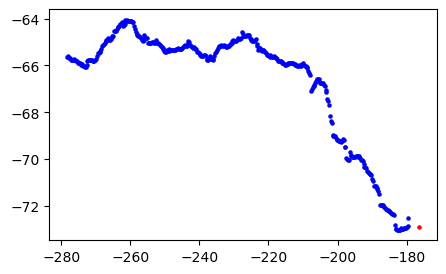

In [21]:
fig = plt.figure(figsize=(5,3))
plt.scatter(S1_lon_bin_midpoints,S1_lat_bin_midpoints,c='blue',s=5,label='S1')
plt.scatter(S2_lon_bin_midpoints,S2_lat_bin_midpoints,c='red',s=5,label='S2')

Seems correct again. Notice that differenty from the previous appraoch with solely zonal binning, here some points started missing on the edges of the sections. That is because midpoints are calculated in a way that each binning should use the same ammount of total valid, non-nan, non-0 points to average from. So when using continously zonal binning in the whole isobath extension, we end up having noedges, except by the model edges. When changing the binning from zonal to meridional, we end up having more edges, and dimishing the total of points in each section. **Discuss this on the ASC meeting and with Adele**

In [22]:
R_lo20

-177.74999999999903

(-200.0, -160.0)

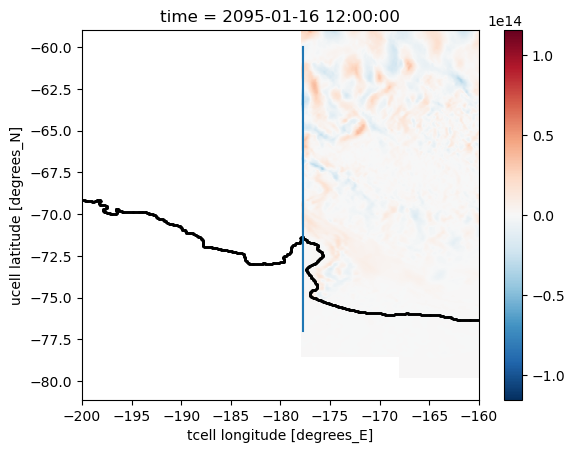

In [23]:
temp_yflux0=temp_yflux; temp_yflux0=temp_yflux0.where(xt_ocean>=R_lo20-0.15, np.nan)

temp_yflux0.plot()
plt.scatter(lon_along_contour,lat_along_contour,c='black',s=1,label='Zonal convergence')# 1st section: bin by lon
plt.plot([R_lo20,R_lo20],[-77,-60])
plt.xlim(-200,-160)


In [24]:
bin_edge_indices_north,bin_edge_indices_south,n_bins

(array([1670]), array([1792]), 1)

In [25]:
	print('Calculating meridional heat convergence for S2')
	# Need to make sure the zonal boundaries here match exactly with the zonal boundaries used for the 
	# longitude averaging above, by using same bin_edge_indices.
	# Just check if isobath point is on x or y grid. if x, sum up to this point from south.
	# if on y grid, sum zonal transport on nearest u grid point to west.
	
	merid_heat_trans_north = np.zeros(n_bins)*np.nan
	for lat_bin in range(n_bins):
	    # north limit:
	    # reset these to False:
	    on_x_grid = False
	    on_y_grid = False
	    # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
	    isobath_north_index = int(bin_edge_indices_north[lat_bin]+1)
	    # check if the point is on the x or y transport grid:
	    if len(np.where(mask_x_transport_numbered==isobath_north_index)[0])>0:
	        on_x_grid = True
	        jj = int(np.where(mask_x_transport_numbered==isobath_north_index)[0])
	        ii = int(np.where(mask_x_transport_numbered==isobath_north_index)[1])
	    elif len(np.where(mask_y_transport_numbered==isobath_north_index)[0])>0:
	        on_y_grid = True
	        jj = int(np.where(mask_y_transport_numbered==isobath_north_index)[0])
	        ii = int(np.where(mask_y_transport_numbered==isobath_north_index)[1])
	    #removing unwanted values for integration (i.e., anything west of the reference line):
	    # THe -0.15 hre is added to we allw the nearest west point on the xgrid to still be in the calculations
	    temp_yflux0=temp_yflux; temp_yflux0=temp_yflux0.where(xt_ocean>=R_lo20-0.11, np.nan)
	    if on_y_grid == True:
	        print('Value on ygrid')
	        # In the case of the ygrid here we want to sum all long points from R_lo20i until the proper ii index
	        merid_heat_trans_north[lat_bin] = np.nansum(temp_yflux0[jj,:ii-1])
	    elif on_x_grid == True:
	        print('Value on xgrid')
	        # in this case we want transport half a grid point to the south:
	        # careful if ii=0, then we need heat trans from lon=80, because at limit of zonal grid
	        #if ii==0:
	            #merid_heat_trans_north[lat_bin] = np.sum(temp_yflux[:jj+1,-1])
	        #else:
	        merid_heat_trans_north[lat_bin] = np.nansum(temp_yflux0[jj-1,:ii+1])   
	        print(np.array(temp_yflux0[jj-1,:ii+1]))
	                
	print('merid_heat_trans_north='+str(merid_heat_trans_north))
	merid_heat_trans_south = np.zeros(n_bins)
	for lat_bin in range(n_bins):
	    # east limit:
	    # reset these to False:
	    on_x_grid = False
	    on_y_grid = False
	    # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
	    isobath_south_index = int(bin_edge_indices_south[lat_bin]+1)
	    # check if the point is on the x or y transport grid:
	    if len(np.where(mask_x_transport_numbered==isobath_south_index)[0])>0:
	        on_x_grid = True
	        jj = int(np.where(mask_x_transport_numbered==isobath_south_index)[0])
	        ii = int(np.where(mask_x_transport_numbered==isobath_south_index)[1])
	    elif len(np.where(mask_y_transport_numbered==isobath_south_index)[0])>0:
	        on_y_grid = True
	        jj = int(np.where(mask_y_transport_numbered==isobath_south_index)[0])
	        ii = int(np.where(mask_y_transport_numbered==isobath_south_index)[1])
	    #removing unwanted values for integration (i.e., anything west of the reference line):
	    # THe -0.15 hre is added to we allw the nearest west point on the xgrid to still be in the calculations
	    temp_yflux0=temp_yflux; temp_yflux0=temp_yflux0.where(xt_ocean>=R_lo20-0.11, np.nan)
	    if on_y_grid == True:
	        print('Value on ygrid')
	        merid_heat_trans_south[lat_bin] = np.nansum(temp_yflux0[jj,:ii])
	    # in this case we want transport half a grid point to the west:
	    elif on_x_grid == True:
	        print('Value on xgrid')
	        # wrap around to east side of grid:
	        # if ii==0:
	        #     zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux[:jj+1,-1])
	        # else:
	        merid_heat_trans_south[lat_bin] = np.nansum(temp_yflux0[jj-1,:ii-1])
	
	print('merid_heat_trans_south='+str(merid_heat_trans_south))
	meridional_convergence = merid_heat_trans_south - merid_heat_trans_north
	print('meridional_convergence='+str(meridional_convergence))

Calculating meridional heat convergence for S2
Value on xgrid
[           nan            nan            nan ...            nan
 -3.7387626e+11  7.8045151e+11]
merid_heat_trans_north=[4.06575251e+11]
Value on xgrid
merid_heat_trans_south=[1.66422842e+13]
meridional_convergence=[1.62357089e+13]


Note for above for continuation. For some reason, if I mask values west of the line limit on the ross sea, the north transport sums up to 0. THis might be just an error on the tecnice I am using (e.g., wrongfully masking the matrix) or the sum might be 0 indeed. Ill have to check that

In [26]:
Shelf_convergence = np.append(S1_zonal_convergence,meridional_convergence)
del meridional_convergence

#### Section 3 binning (zonal)

As it shows below, in this limit we do not need to mask out the WAP for the integration of zonal convergence south of the Isobath

(-100.0, -40.0)

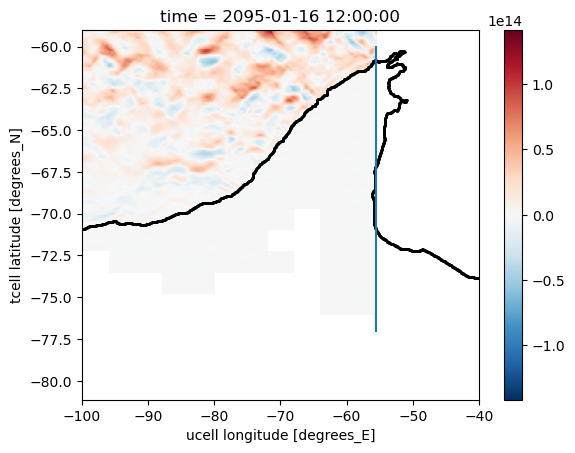

In [27]:
temp_xflux0=temp_xflux; temp_xflux0=temp_xflux0.where(xu_ocean<=A_lo20, np.nan)

temp_xflux0.plot()
plt.scatter(lon_along_contour,lat_along_contour,c='black',s=1,label='Zonal convergence')# 1st section: bin by lon
plt.plot([A_lo20,A_lo20],[-77,-60])
plt.xlim(-100,-40)

In [28]:
lon_along_contour[S2_ilim+1:S3_ilim]

array([-176.85, -176.9 , -176.9 , ...,  -55.65,  -55.55,  -55.45])

In [29]:
	#Section 3, zonal binning
	S3_lon_coord = np.arange(S3_first_lon,S3_last_lon+lon_bin_spacing,lon_bin_spacing)   
	S3_lon_bin_midpoints = np.arange(S3_first_lon+lon_bin_width/2,S3_last_lon-lon_bin_width/2,lon_bin_spacing)
	S3_n_bin_edges = len(S3_lon_coord)
	
	# sum into longitude bins:
	# need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
	# on the isobath contour and sum continously along contour between defined indices.
	# (i.e. lon_along_contour is not monotonic)
	# find points on contour to define edges of longitude bins:
	bin_edge_indices = np.zeros(S3_n_bin_edges)
	for lon_bin in range(S3_n_bin_edges-1):
	    # find first isobath point that has the right longitude:
	    first_point = np.where(lon_along_contour[S2_ilim+1:S3_ilim]>=S3_lon_coord[lon_bin])[0][0]+S2_ilim+1
	    # then find all other isobath points with the same longitude as that first point:
	    same_lon_points = np.where(lon_along_contour[S2_ilim+1:S3_ilim]==lon_along_contour[first_point])[0]+S2_ilim+1
	    # we want the most southerly of these points on the same longitude line:
	    bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points])]
	    #print('bin_edge_indices='+str(bin_edge_indices)+'\n\n')
	    
	# define east/west edges:
	bin_edge_indices = bin_edge_indices.astype(int)
	bin_edge_indices_west = bin_edge_indices[:-int(lon_bin_width/lon_bin_spacing)-1]
	bin_edge_indices_east = bin_edge_indices[int(lon_bin_width/lon_bin_spacing):-1]
	n_bins = len(bin_edge_indices_west)
	print('n_bins='+str(n_bins))
	
	# sum heat transport from isobath coord into new longitude coord:
	S3_cross_slope_heat_trans = np.zeros(n_bins)
	for lon_bin in range(n_bins):
	    S3_heat_trans_this_bin = heat_trans_across_contour[bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
	    S3_cross_slope_heat_trans[lon_bin] = np.sum(S3_heat_trans_this_bin)
	    
	# find average latitude of each bin, so we can plot back on the isobath:
	S3_lat_bin_midpoints = np.zeros(n_bins)
	for lon_bin in range(n_bins):
	    # find nearest isobath point:
	    S3_lon_index = np.where(lon_along_contour[S2_ilim+1:S3_ilim]>=S3_lon_bin_midpoints[lon_bin])[0][0]+S2_ilim+1
	    S3_lat_bin_midpoints[lon_bin] = lat_along_contour[S3_lon_index]
	
	

n_bins=474


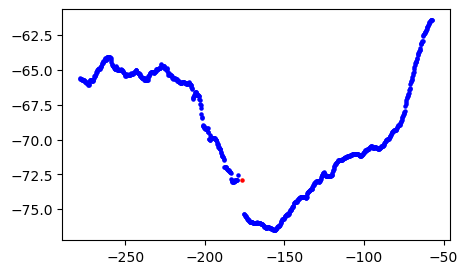

In [30]:
fig = plt.figure(figsize=(5,3))
plt.scatter(S1_lon_bin_midpoints,S1_lat_bin_midpoints,c='blue',s=5,label='S1')
plt.scatter(S2_lon_bin_midpoints,S2_lat_bin_midpoints,c='red',s=5,label='S2')
plt.scatter(S3_lon_bin_midpoints,S3_lat_bin_midpoints,c='blue',s=5,label='S3')

In [31]:
	print('Calculating Zonal heat convergence for S3')
	# Need to make sure the zonal boundaries here match exactly with the zonal boundaries used for the 
	# longitude averaging above, by using same bin_edge_indices.
	# Just check if isobath point is on x or y grid. if x, sum up to this point from south.
	# if on y grid, sum zonal transport on nearest u grid point to west.
	
	zonal_heat_trans_west = np.zeros(n_bins)
	for lon_bin in range(n_bins):
	    # west limit:
	    # reset these to False:
	    on_x_grid = False
	    on_y_grid = False
	    # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
	    isobath_west_index = int(bin_edge_indices_west[lon_bin]+1)
	    # check if the point is on the x or y transport grid:
	    if len(np.where(mask_x_transport_numbered==isobath_west_index)[0])>0:
	        on_x_grid = True
	        jj = int(np.where(mask_x_transport_numbered==isobath_west_index)[0])
	        ii = int(np.where(mask_x_transport_numbered==isobath_west_index)[1])
	    elif len(np.where(mask_y_transport_numbered==isobath_west_index)[0])>0:
	        on_y_grid = True
	        jj = int(np.where(mask_y_transport_numbered==isobath_west_index)[0])
	        ii = int(np.where(mask_y_transport_numbered==isobath_west_index)[1])
	    if on_x_grid == True:
	        zonal_heat_trans_west[lon_bin] = np.sum(temp_xflux[:jj,ii]) 
	    # in this case we want transport half a grid point to the west:
	    elif on_y_grid == True:
	        # careful if ii=0, then we need heat trans from lon=80, because at limit of zonal grid
	        if ii==0:
	            zonal_heat_trans_west[lon_bin] = np.sum(temp_xflux[:jj+1,-1])
	        else:
	            zonal_heat_trans_west[lon_bin] = np.sum(temp_xflux[:jj+1,ii-1])
	
	zonal_heat_trans_east = np.zeros(n_bins)
	for lon_bin in range(n_bins):
	    # east limit:
	    # reset these to False:
	    on_x_grid = False
	    on_y_grid = False
	    # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
	    isobath_east_index = int(bin_edge_indices_east[lon_bin]+1)
	    # check if the point is on the x or y transport grid:
	    if len(np.where(mask_x_transport_numbered==isobath_east_index)[0])>0:
	        on_x_grid = True
	        jj = int(np.where(mask_x_transport_numbered==isobath_east_index)[0])
	        ii = int(np.where(mask_x_transport_numbered==isobath_east_index)[1])
	    elif len(np.where(mask_y_transport_numbered==isobath_east_index)[0])>0:
	        on_y_grid = True
	        jj = int(np.where(mask_y_transport_numbered==isobath_east_index)[0])
	        ii = int(np.where(mask_y_transport_numbered==isobath_east_index)[1])
	    if on_x_grid == True:
	        zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux[:jj,ii])
	    # in this case we want transport half a grid point to the west:
	    elif on_y_grid == True:
	        # wrap around to east side of grid:
	        if ii==0:
	            zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux[:jj+1,-1])
	        else:
	            zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux[:jj+1,ii-1])
	
	zonal_convergence = zonal_heat_trans_east - zonal_heat_trans_west

Calculating Zonal heat convergence for S3


Creating a running mean fucntion just to see how the convergence looks and compare with previous plots

In [32]:
Shelf_convergence = np.append(Shelf_convergence,zonal_convergence)
del zonal_convergence
full_binned_lon = np.append(np.append(S1_lon_bin_midpoints,S2_lon_bin_midpoints),S3_lon_bin_midpoints)

In [33]:
def running_mean(x, N):
    cumsum = np.nancumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

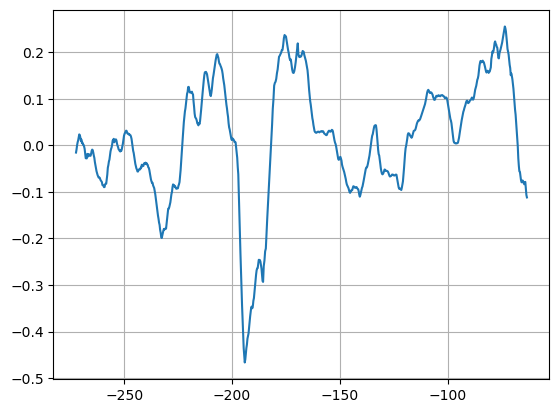

In [34]:
swin=50
plt.plot(running_mean(np.array(full_binned_lon),swin),
         running_mean(np.array(Shelf_convergence*0.08),swin)/1e12)
plt.grid()

Heat convergente looks ok until now

How tdid the edge here, on the Antarctic peninsula looks like? So we can evaluate the issue described on cell 8

In [35]:
print('Edge of the unbinned EAP=' + str(lon_along_contour[S3_ilim])+
      '\n\nEdge of the binned EAP='+str(S3_lon_bin_midpoints[-1]))


Edge of the unbinned EAP=-55.500000000005365

Edge of the binned EAP=-57.099999999999056


In [36]:
import cartopy.feature as cft
import cartopy.crs as ccrs
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='papayawhip', linewidth=0.5)

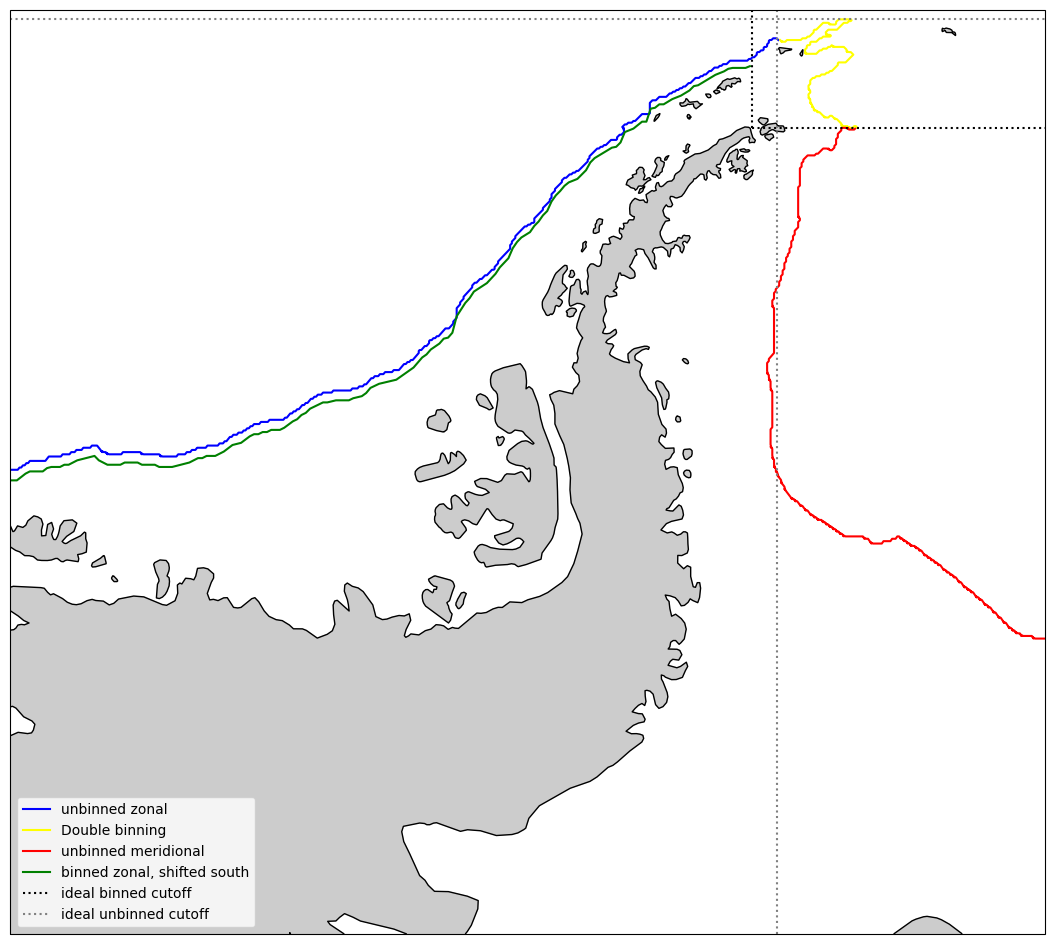

In [37]:
fig = plt.figure(figsize=(18, 12))
ax = plt.axes(projection=ccrs.Mercator(central_longitude=-60, min_latitude=-78, max_latitude=-60.0))

ax.set_extent([-100, -40, -78, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])


#temp_xflux.plot(x='xu_ocean',y='yt_ocean',transform=ccrs.PlateCarree())
#plt.plot(lon_along_contour, lat_along_contour, 
#         transform=ccrs.PlateCarree(),color='yellow',label='full initial contour')

#unbinned points:
plt.plot(lon_along_contour[:S3_ilim], lat_along_contour[:S3_ilim], 
         transform=ccrs.PlateCarree(),color='blue',label='unbinned zonal')
plt.plot(lon_along_contour[S3_ilim+1:S35_ilim], lat_along_contour[S3_ilim+1:S35_ilim], 
         transform=ccrs.PlateCarree(),color='yellow',label='Double binning')
plt.plot(lon_along_contour[S35_ilim:], lat_along_contour[S35_ilim:], 
         transform=ccrs.PlateCarree(),color='red',label='unbinned meridional')



#binned points:
plt.plot(S3_lon_bin_midpoints, S3_lat_bin_midpoints-0.2, 
         transform=ccrs.PlateCarree(),color='green',label='binned zonal, shifted south')

#Ideal line:
plt.plot([-57,-57], [-63.25,-60], 
         transform=ccrs.PlateCarree(),color='black',linestyle=':',label='ideal binned cutoff')
plt.plot([-57,-40], [-63.25,-63.25], 
         transform=ccrs.PlateCarree(),color='black',linestyle=':')
plt.plot([-55.5,-55.5], [-78,-60], 
         transform=ccrs.PlateCarree(),color='gray',linestyle=':',label='ideal unbinned cutoff')
plt.plot([-100,-40], [-60.25,-60.25], 
         transform=ccrs.PlateCarree(),color='gray',linestyle=':')

plt.legend()
ax.coastlines();


We want the S3 section to cut off in the location of the line + 3 of the binning (~-55W). ANother thing that I realize is that for the zonal binning in the ANtarctic penunsla, I will also need to make a mask to mask out the West Anntarctic penisula otherwise the zonal convergence will take into account part of th WAP (because it sums up everything South of it)

#### Section 3.5 binning (zonal+meridional)

This section is more challenging since we will need to calculate both the zonal and meridional heat convergence, because the shelf here is just opened meridionally and zonalluy. This means that this whole section will be one single bin, and we will need to calculate the mean heat transport in it + zonal convergence in the edges of this bin + meridional convergence in the edge of this bin. 

First lets calculate the meridional convergence

In [38]:
	#Section 35, meridional binning, leading coordinate is latitude
	S35_lat_coord = np.arange(S35_first_lat,S35_last_lat-lat_bin_spacing,-lat_bin_spacing)   
	S35_lon_coord = np.arange(S35_first_lon,S35_last_lon+lon_bin_spacing,lon_bin_spacing)  
	#Here we will force to have just one midpoint, to make it easier
	S35_lat_bin_midpoints = (S35_first_lat+S35_last_lat)/2
	S35_lon_bin_midpoints = (S35_first_lon+S35_last_lon)/2
	S35_n_bin_edges = len(S35_lat_coord)
	print( "Lat Midpoints are: " +str(S35_lat_bin_midpoints) +
          "\n\nLon Midpoints are: " +str(S35_lon_bin_midpoints) +
          '\n\nLatitudes are' + str(S35_lat_coord) + '\n\nLongitudes are' + str(S35_lon_coord))

Lat Midpoints are: -62.066056805203374

Lon Midpoints are: -53.17500000000534

Latitudes are[-60.86050798 -61.11050798 -61.36050798 -61.61050798 -61.86050798
 -62.11050798 -62.36050798 -62.61050798 -62.86050798 -63.11050798
 -63.36050798]

Longitudes are[-55.35 -55.1  -54.85 -54.6  -54.35 -54.1  -53.85 -53.6  -53.35 -53.1
 -52.85 -52.6  -52.35 -52.1  -51.85 -51.6  -51.35 -51.1  -50.85]


In [39]:
	bin_edge_indices = np.zeros(S35_n_bin_edges)
	for lat_bin in range(S35_n_bin_edges-1):
	    # Direction of latitude change along the contour is different (go towards negative values instead of positive ones)
	    #Notice because lat goes north and south randomly, we have to constrain the where to the location of work
	    first_point = np.where(lat_along_contour[S3_ilim+1:S35_ilim]<=S35_lat_coord[lat_bin])[0][0]+S3_ilim+1
	    #print('FP='+str(first_point)+'\n\n')        
	    # then find all other isobath points with the same latitude as that first point:
	    same_lat_points = np.where(lat_along_contour[S3_ilim+1:S35_ilim]==lat_along_contour[first_point])[0]+S3_ilim+1
	    #print('FP='+str(first_point)+'\nSLatP='+str(same_lat_points)+'\n\n')
	    # we want the most easternmost of these points on the same latitude line:
	    bin_edge_indices[lat_bin] = same_lat_points[np.argmax(lon_along_contour[same_lat_points])]
	    print('bin_edge_indices='+str(bin_edge_indices)+'\n\n')
	    
	# define north/south edges:
	bin_edge_indices = bin_edge_indices.astype(int)
	bin_edge_indices_north = bin_edge_indices[0] #Changed to zero here so we can have propper edges for 1 bin
	print('bin_edge_indices_north='+str(bin_edge_indices_north)+'\n\n')
	bin_edge_indices_south = bin_edge_indices[-2] #Changed to zero here so we can have propper edges for 1 bin
	print('bin_edge_indices_south='+str(bin_edge_indices_south)+'\n\n')
	n_bins = 1 #Changed to zero here so we can have propper edges for 1 bin
	print('n_bins='+str(n_bins))
	    
	# sum heat transport from isobath coord into new longitude coord:
	S35_cross_slope_heat_trans = np.zeros(n_bins)
	
	S35_heat_trans_this_bin = heat_trans_across_contour[bin_edge_indices_north:bin_edge_indices_south]
	S35_cross_slope_heat_trans = np.sum(S35_heat_trans_this_bin)
	print('cross slope heat transport on AP = '+ str(S35_cross_slope_heat_trans/1e12) + ' TW')  
	# find average longitude of each bin, so we can plot back on the isobath:
	S35_lon_bin_midpoints = np.zeros(n_bins)
	for lat_bin in range(n_bins):
	    # find nearest isobath point:
	    S35_lat_index = np.where(lat_along_contour[S3_ilim+1:S35_ilim]<=S35_lat_bin_midpoints)[0][0]+S3_ilim+1
	    S35_lon_bin_midpoints = lon_along_contour[S35_lat_index]
	

bin_edge_indices=[3590.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]


bin_edge_indices=[3590. 3637.    0.    0.    0.    0.    0.    0.    0.    0.    0.]


bin_edge_indices=[3590. 3637. 3648.    0.    0.    0.    0.    0.    0.    0.    0.]


bin_edge_indices=[3590. 3637. 3648. 3662.    0.    0.    0.    0.    0.    0.    0.]


bin_edge_indices=[3590. 3637. 3648. 3662. 3676.    0.    0.    0.    0.    0.    0.]


bin_edge_indices=[3590. 3637. 3648. 3662. 3676. 3688.    0.    0.    0.    0.    0.]


bin_edge_indices=[3590. 3637. 3648. 3662. 3676. 3688. 3696.    0.    0.    0.    0.]


bin_edge_indices=[3590. 3637. 3648. 3662. 3676. 3688. 3696. 3701.    0.    0.    0.]


bin_edge_indices=[3590. 3637. 3648. 3662. 3676. 3688. 3696. 3701. 3713.    0.    0.]


bin_edge_indices=[3590. 3637. 3648. 3662. 3676. 3688. 3696. 3701. 3713. 3731.    0.]


bin_edge_indices_north=3590


bin_edge_indices_south=3731


n_bins=1
cross slope heat transport on AP = 7.11134113792 TW


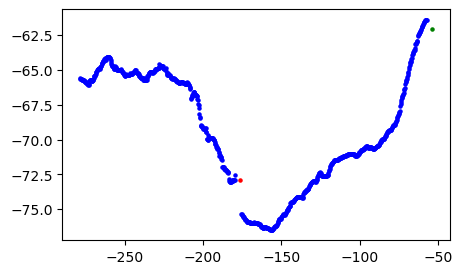

In [40]:
fig = plt.figure(figsize=(5,3))
plt.scatter(S1_lon_bin_midpoints,S1_lat_bin_midpoints,c='blue',s=5,label='S1')
plt.scatter(S2_lon_bin_midpoints,S2_lat_bin_midpoints,c='red',s=5,label='S2')
plt.scatter(S3_lon_bin_midpoints,S3_lat_bin_midpoints,c='blue',s=5,label='S3')
plt.scatter(S35_lon_bin_midpoints,S35_lat_bin_midpoints,c='green',s=5,label='S35')

Coordinates seems correct

Now calculating the meridional convergence

In [41]:
	print('Calculating meridional heat convergence for S35')
	# Need to make sure the zonal boundaries here match exactly with the zonal boundaries used for the 
	# longitude averaging above, by using same bin_edge_indices.
	# Just check if isobath point is on x or y grid. if x, sum up to this point from south.
	# if on y grid, sum zonal transport on nearest u grid point to west.
	
	merid_heat_trans_north = np.zeros(n_bins)*np.nan
	for lat_bin in range(n_bins):
	    # north limit:
	    # reset these to False:
	    on_x_grid = False
	    on_y_grid = False
	    # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
	    isobath_north_index = int(bin_edge_indices_north+1)
	    # check if the point is on the x or y transport grid:
	    if len(np.where(mask_x_transport_numbered==isobath_north_index)[0])>0:
	        on_x_grid = True
	        jj = int(np.where(mask_x_transport_numbered==isobath_north_index)[0])
	        ii = int(np.where(mask_x_transport_numbered==isobath_north_index)[1])
	    elif len(np.where(mask_y_transport_numbered==isobath_north_index)[0])>0:
	        on_y_grid = True
	        jj = int(np.where(mask_y_transport_numbered==isobath_north_index)[0])
	        ii = int(np.where(mask_y_transport_numbered==isobath_north_index)[1])
	    #removing unwanted values for integration (i.e., anything west of the reference line):
	    # THe -0.15 hre is added to we allw the nearest west point on the xgrid to still be in the calculations
	    temp_yflux0=temp_yflux; temp_yflux0=temp_yflux0.where(xt_ocean>=A_lo20-0.11, np.nan)
	    if on_y_grid == True:
	        print('Value on ygrid')
	        # In the case of the ygrid here we want to sum all long points from A_lo20i until the proper ii index
	        merid_heat_trans_north[lat_bin] = np.nansum(temp_yflux0[jj,:ii])
	    elif on_x_grid == True:
	        print('Value on xgrid')
	        # in this case we want transport half a grid point to the south:
	        # careful if ii=0, then we need heat trans from lon=80, because at limit of zonal grid
	        #if ii==0:
	            #merid_heat_trans_north[lat_bin] = np.sum(temp_yflux[:jj+1,-1])
	        #else:
	        merid_heat_trans_north[lat_bin] = np.nansum(temp_yflux0[jj-1,:ii-1])   
	        #print(np.array(temp_yflux0[jj-1,:ii-1]))
	                
	print('merid_heat_trans_north='+str(merid_heat_trans_north))
	merid_heat_trans_south = np.zeros(n_bins)*np.nan
	for lat_bin in range(n_bins):
	    # east limit:
	    # reset these to False:
	    on_x_grid = False
	    on_y_grid = False
	    # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
	    isobath_south_index = int(bin_edge_indices_south+1)
	    # check if the point is on the x or y transport grid:
	    if len(np.where(mask_x_transport_numbered==isobath_south_index)[0])>0:
	        on_x_grid = True
	        jj = int(np.where(mask_x_transport_numbered==isobath_south_index)[0])
	        ii = int(np.where(mask_x_transport_numbered==isobath_south_index)[1])
	    elif len(np.where(mask_y_transport_numbered==isobath_south_index)[0])>0:
	        on_y_grid = True
	        jj = int(np.where(mask_y_transport_numbered==isobath_south_index)[0])
	        ii = int(np.where(mask_y_transport_numbered==isobath_south_index)[1])
	    #removing unwanted values for integration (i.e., anything west of the reference line):
	    # THe -0.15 hre is added to we allw the nearest west point on the xgrid to still be in the calculations
	    temp_yflux0=temp_yflux; temp_yflux0=temp_yflux0.where(xt_ocean>=A_lo20-0.11, np.nan)
	    if on_y_grid == True:
	        print('Value on ygrid')
	        merid_heat_trans_south[lat_bin] = np.nansum(temp_yflux0[jj,:ii])
	    # in this case we want transport half a grid point to the west:
	    elif on_x_grid == True:
	        print('Value on xgrid')
	        # wrap around to east side of grid:
	        # if ii==0:
	        #     zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux[:jj+1,-1])
	        # else:
	        merid_heat_trans_south[lat_bin] = np.nansum(temp_yflux0[jj-1,:ii-1])
	
	print('merid_heat_trans_south='+str(merid_heat_trans_south))
	meridional_convergence = merid_heat_trans_south - merid_heat_trans_north
	print('meridional_convergence='+str(meridional_convergence))

Calculating meridional heat convergence for S35
Value on ygrid
merid_heat_trans_north=[1.20542839e+13]
Value on ygrid
merid_heat_trans_south=[1.16512984e+13]
meridional_convergence=[-4.02985583e+11]


Now lets calculate the zonal convergence. For calculating the zonal heat convergence we will need to define teh east and west edge of the longitude bins. We hit the jackpothere because by checking the earlyer map (yellow line), you can see that the north edge is also the west edhe, and the South edge is also the East edge. So:

In [42]:
	bin_edge_indices_west = bin_edge_indices_north
	bin_edge_indices_east = bin_edge_indices_south

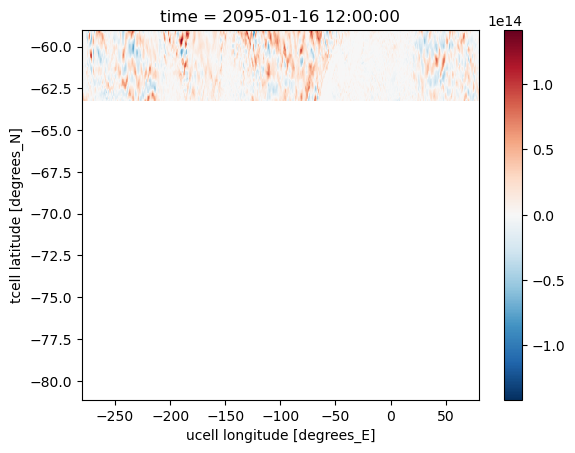

In [43]:
temp_xflux0=temp_xflux; temp_xflux0=temp_xflux0.where(yt_ocean>=S35_lat_coord[-1]+0.11)
temp_xflux0.plot()

In [44]:
	print('Calculating Zonal heat convergence for S35')
	# Need to make sure the zonal boundaries here match exactly with the zonal boundaries used for the 
	# longitude averaging above, by using same bin_edge_indices.
	# Just check if isobath point is on x or y grid. if x, sum up to this point from south.
	# if on y grid, sum zonal transport on nearest u grid point to west.
	
	zonal_heat_trans_west = np.zeros(n_bins)
	for lon_bin in range(n_bins):
	    # west limit:
	    # reset these to False:
	    on_x_grid = False
	    on_y_grid = False
	    # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
	    isobath_west_index = int(bin_edge_indices_west+1)
	    # check if the point is on the x or y transport grid:
	    if len(np.where(mask_x_transport_numbered==isobath_west_index)[0])>0:
	        on_x_grid = True
	        jj = int(np.where(mask_x_transport_numbered==isobath_west_index)[0])
	        ii = int(np.where(mask_x_transport_numbered==isobath_west_index)[1])
	    elif len(np.where(mask_y_transport_numbered==isobath_west_index)[0])>0:
	        on_y_grid = True
	        jj = int(np.where(mask_y_transport_numbered==isobath_west_index)[0])
	        ii = int(np.where(mask_y_transport_numbered==isobath_west_index)[1])
	    # I will need to remove from the calculation the xtransports below the South limit of the Section 35. Lets mask it then
	    temp_xflux0=temp_xflux; temp_xflux0=temp_xflux0.where(yt_ocean>=S35_lat_coord[-1]+0.11)
	    if on_x_grid == True:
	        zonal_heat_trans_west[lon_bin] = np.sum(temp_xflux0[:jj,ii]) 
	    # in this case we want transport half a grid point to the west:
	    elif on_y_grid == True:
	        # careful if ii=0, then we need heat trans from lon=80, because at limit of zonal grid
	        if ii==0:
	            zonal_heat_trans_west[lon_bin] = np.sum(temp_xflux0[:jj+1,-1])
	        else:
	            zonal_heat_trans_west[lon_bin] = np.sum(temp_xflux0[:jj+1,ii-1])
	
	zonal_heat_trans_east = np.zeros(n_bins)
	for lon_bin in range(n_bins):
	    # east limit:
	    # reset these to False:
	    on_x_grid = False
	    on_y_grid = False
	    # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
	    isobath_east_index = int(bin_edge_indices_east+1)
	    # check if the point is on the x or y transport grid:
	    if len(np.where(mask_x_transport_numbered==isobath_east_index)[0])>0:
	        on_x_grid = True
	        jj = int(np.where(mask_x_transport_numbered==isobath_east_index)[0])
	        ii = int(np.where(mask_x_transport_numbered==isobath_east_index)[1])
	    elif len(np.where(mask_y_transport_numbered==isobath_east_index)[0])>0:
	        on_y_grid = True
	        jj = int(np.where(mask_y_transport_numbered==isobath_east_index)[0])
	        ii = int(np.where(mask_y_transport_numbered==isobath_east_index)[1])
	    # I will need to remove from the calculation the xtransports below the South limit of the Section 35. Lets mask it then
	    temp_xflux0=temp_xflux; temp_xflux0=temp_xflux0.where(yt_ocean>=S35_lat_coord[-1]+0.11)
	    if on_x_grid == True:
	        zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux0[:jj,ii])
	    # in this case we want transport half a grid point to the west:
	    elif on_y_grid == True:
	        # wrap around to east side of grid:
	        if ii==0:
	            zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux0[:jj+1,-1])
	        else:
	            zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux0[:jj+1,ii-1])
	
	zonal_convergence = zonal_heat_trans_east - zonal_heat_trans_west
	print('zonal_convergence='+str(zonal_convergence))

Calculating Zonal heat convergence for S35
zonal_convergence=[4.8860935e+11]


Total convergence will then be the zonal + meridional convergence:

In [45]:
	S35_total_convergence = zonal_convergence + meridional_convergence
	print('Total_convergence='+str(S35_total_convergence))

Total_convergence=[8.5623767e+10]


In [46]:
Shelf_convergence = np.append(Shelf_convergence,S35_total_convergence)
del zonal_convergence,meridional_convergence,S35_total_convergence



In [47]:
full_binned_lon = np.append(np.append(np.append(S1_lon_bin_midpoints,S2_lon_bin_midpoints),S3_lon_bin_midpoints),S35_lon_bin_midpoints)
full_binned_lat = np.append(np.append(np.append(S1_lat_bin_midpoints,S2_lat_bin_midpoints),S3_lat_bin_midpoints),S35_lat_bin_midpoints)
Full_binned_transport = np.append(np.append(np.append(S1_cross_slope_heat_trans,S2_cross_slope_heat_trans),S3_cross_slope_heat_trans),S35_cross_slope_heat_trans)


LEts check how things are looking

Text(0.5, 1.0, 'Cross Slope Heat Transport +Shelf Convergence')

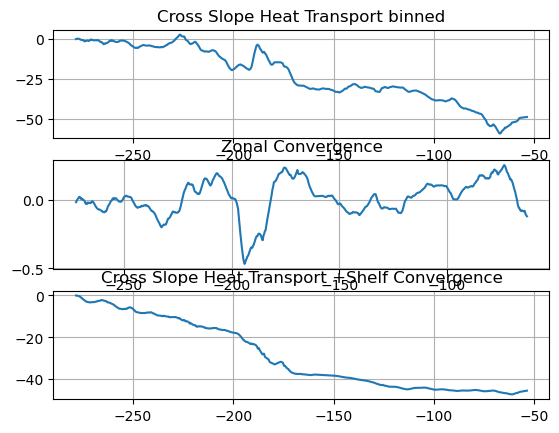

In [48]:
plt.subplot(3,1,1)

plt.plot(full_binned_lon,np.cumsum(Full_binned_transport)*0.08/1e12)
plt.grid(); plt.title('Cross Slope Heat Transport binned')

plt.subplot(3,1,2)
swin=50
plt.plot(running_mean(np.array(full_binned_lon),swin),
         running_mean(np.array(Shelf_convergence*0.08),swin)/1e12)
plt.grid(); plt.title('Zonal Convergence')

plt.subplot(3,1,3)
plt.plot(full_binned_lon,np.cumsum(Full_binned_transport+Shelf_convergence)*0.08/1e12)
plt.grid(); plt.title('Cross Slope Heat Transport +Shelf Convergence')



Next stop is section 4, where we only will care about the meridional convergence, since is a very meridional coast

#### Section 4 binning (meridional)

This is Finally the east of the Antarctic Peninsula, where we will just bin things meridionaly, and discount the merridional divergence.

In [49]:
	#Section 4, meridional binning, leading coordinate is latitude
	S4_lat_coord = np.arange(S4_first_lat,S4_last_lat-lat_bin_spacing,-lat_bin_spacing)   
	S4_lat_bin_midpoints = np.arange(S4_first_lat-lat_bin_width/2,S4_last_lat+lat_bin_width/2,-lat_bin_spacing)
	S4_n_bin_edges = len(S4_lat_coord)
	print( "Midpoints are: " +str(S4_lat_bin_midpoints) + '\n\nLatitudes are' + str(S4_lat_coord))



Midpoints are: [-64.79407615 -65.04407615 -65.29407615 -65.54407615 -65.79407615
 -66.04407615 -66.29407615 -66.54407615 -66.79407615 -67.04407615
 -67.29407615 -67.54407615 -67.79407615 -68.04407615 -68.29407615
 -68.54407615 -68.79407615 -69.04407615 -69.29407615 -69.54407615]

Latitudes are[-63.29407615 -63.54407615 -63.79407615 -64.04407615 -64.29407615
 -64.54407615 -64.79407615 -65.04407615 -65.29407615 -65.54407615
 -65.79407615 -66.04407615 -66.29407615 -66.54407615 -66.79407615
 -67.04407615 -67.29407615 -67.54407615 -67.79407615 -68.04407615
 -68.29407615 -68.54407615 -68.79407615 -69.04407615 -69.29407615
 -69.54407615 -69.79407615 -70.04407615 -70.29407615 -70.54407615
 -70.79407615 -71.04407615 -71.29407615]


In [50]:
	bin_edge_indices = np.zeros(S4_n_bin_edges)
	for lat_bin in range(S4_n_bin_edges-1):
	    # Direction of latitude change along the contour is different (go towards negative values instead of positive ones)
	    #Notice because lat goes north and south randomly, we have to constrain the where to the location of work
	    first_point = np.where(lat_along_contour[S35_ilim+1:S4_ilim]<=S4_lat_coord[lat_bin])[0][0]+S35_ilim+1
	    #print('FP='+str(first_point)+'\n\n')        
	    # then find all other isobath points with the same latitude as that first point:
	    same_lat_points = np.where(lat_along_contour[S35_ilim+1:S4_ilim]==lat_along_contour[first_point])[0]+S35_ilim+1
	    #print('FP='+str(first_point)+'\nSLatP='+str(same_lat_points)+'\n\n')
	    # we want the most easternmost of these points on the same latitude line:
	    bin_edge_indices[lat_bin] = same_lat_points[np.argmax(lon_along_contour[same_lat_points])]
	    #print('bin_edge_indices='+str(bin_edge_indices)+'\n\n')
	    
	# define north/south edges:
	bin_edge_indices = bin_edge_indices.astype(int)
	bin_edge_indices_north = bin_edge_indices[:-int(lat_bin_width/lat_bin_spacing)-1]
	print('bin_edge_indices_north='+str(bin_edge_indices_north)+'\n\n')
	bin_edge_indices_south = bin_edge_indices[int(lat_bin_width/lat_bin_spacing):-1]
	print('bin_edge_indices_south='+str(bin_edge_indices_south)+'\n\n')
	n_bins = len(bin_edge_indices_north)
	print('n_bins='+str(n_bins))
	    
	# sum heat transport from isobath coord into new longitude coord:
	S4_cross_slope_heat_trans = np.zeros(n_bins)
	for lat_bin in range(n_bins):
	    S4_heat_trans_this_bin = heat_trans_across_contour[bin_edge_indices_north[lat_bin]:bin_edge_indices_south[lat_bin]]
	    S4_cross_slope_heat_trans[lat_bin] = np.sum(S4_heat_trans_this_bin)
	    
	# find average longitude of each bin, so we can plot back on the isobath:
	S4_lon_bin_midpoints = np.zeros(n_bins)
	for lat_bin in range(n_bins):
	    # find nearest isobath point:
	    S4_lat_index = np.where(lat_along_contour[S35_ilim+1:S4_ilim]<=S4_lat_bin_midpoints[lat_bin])[0][0]+S35_ilim+1
	    S4_lon_bin_midpoints[lat_bin] = lon_along_contour[S4_lat_index]
	
	

bin_edge_indices_north=[3749 3768 3775 3799 3808 3813 3820 3826 3832 3839 3847 3855 3863 3871
 3879 3887 3895 3902 3909 3915]


bin_edge_indices_south=[3863 3871 3879 3887 3895 3902 3909 3915 3921 3927 3937 3944 3951 3958
 3964 3970 3976 3983 3990 3999]


n_bins=20


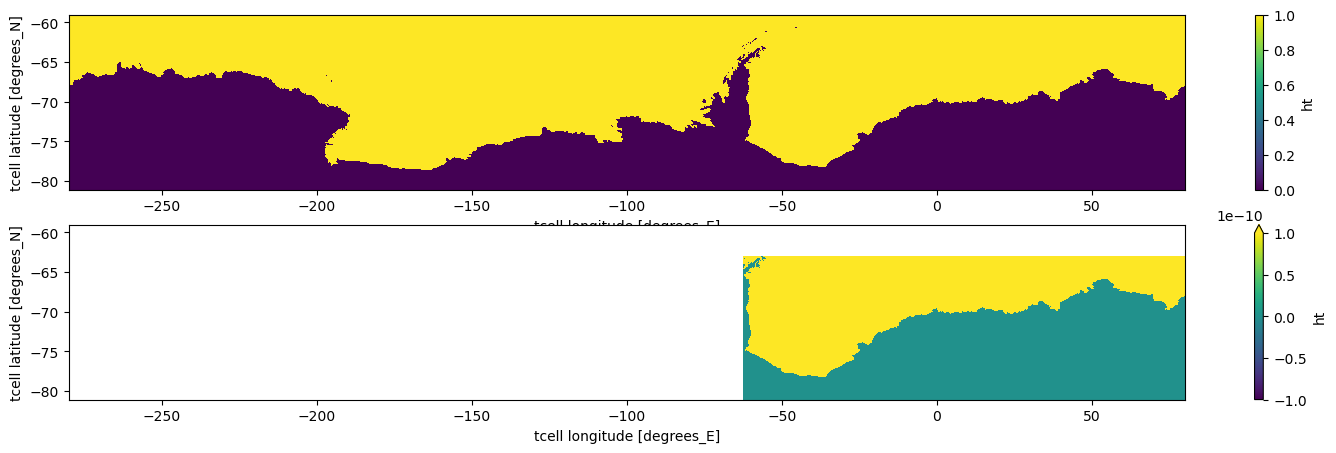

In [51]:
# as seen by these map, to define the limits of integration here we want to amsk out everything west of -68, and everythhing north of the tip of the antarctic penisula
fig = plt.figure(figsize=(18, 5))
plt.subplot(2,1,1)
lmask.plot()
plt.subplot(2,1,2)
lmask0=lmask; lmask0=lmask0.where(xt_ocean>=-62.5, np.nan).where(yt_ocean<=-63)
lmask0.plot(vmin=-1e-10,vmax=1e-10)


**It seems to me that the limits that I put are not very accurate because they were based on the cartogrpahic plot, and not on the edges of the model. I have to recalculate all the limites between sectors respecting now the edges of land in the model**

Seems fine to me here too. Not ideal the fact that we have so many weird gaps. **Discussion topic for the next meeting: SHould we overlap  heat transports in these interfaces between bins?**

Lets calculate the meridional convergence in S4

a special masked tempyflux is required here, where the west of the Antarctic Peninsula is masked. lets create it

(-65.0, -50.0)

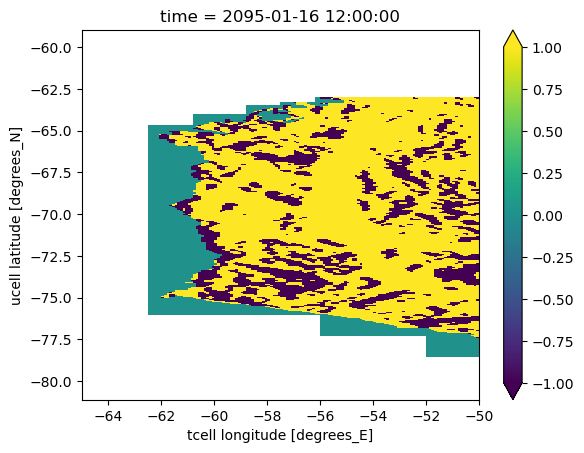

In [52]:
temp_yflux0=temp_yflux; temp_yflux0=temp_yflux0.where(xt_ocean>=-62.5, np.nan).where(yu_ocean<=-63)
temp_yflux0=temp_yflux0.where((xt_ocean>=-60.8) | (yu_ocean<=-64.67), np.nan)
temp_yflux0=temp_yflux0.where((xt_ocean>=-58.8) | (yu_ocean<=-64), np.nan)
temp_yflux0=temp_yflux0.where((xt_ocean>=-57.5) | (yu_ocean<=-63.5), np.nan)
temp_yflux0=temp_yflux0.where((xt_ocean>=-56.2) | (yu_ocean<=-63.3), np.nan)

temp_yflux0.plot(vmin=-1,vmax=1)
plt.xlim(-65,-50)

#temp_yflux0 is the masked tempyflux we will use for this integration

In [53]:
	print('Calculating meridional heat convergence for S4')
	# Need to make sure the zonal boundaries here match exactly with the zonal boundaries used for the 
	# longitude averaging above, by using same bin_edge_indices.
	# Just check if isobath point is on x or y grid. if x, sum up to this point from south.
	# if on y grid, sum zonal transport on nearest u grid point to west.
	
	merid_heat_trans_north = np.zeros(n_bins)*np.nan
	for lat_bin in range(n_bins):
	    # north limit:
	    # reset these to False:
	    on_x_grid = False
	    on_y_grid = False
	    # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
	    isobath_north_index = int(bin_edge_indices_north[lat_bin]+1)
	    # check if the point is on the x or y transport grid:
	    if len(np.where(mask_x_transport_numbered==isobath_north_index)[0])>0:
	        on_x_grid = True
	        jj = int(np.where(mask_x_transport_numbered==isobath_north_index)[0])
	        ii = int(np.where(mask_x_transport_numbered==isobath_north_index)[1])
	    elif len(np.where(mask_y_transport_numbered==isobath_north_index)[0])>0:
	        on_y_grid = True
	        jj = int(np.where(mask_y_transport_numbered==isobath_north_index)[0])
	        ii = int(np.where(mask_y_transport_numbered==isobath_north_index)[1])
	    #removing unwanted values for integration (i.e., anything west of the reference line):
	    # THe -0.15 hre is added to we allw the nearest west point on the xgrid to still be in the calculations
	    #temp_yflux0=temp_yflux; temp_yflux0=temp_yflux0.where(xt_ocean>=-62.5, np.nan).where(yu_ocean<=-63)
	    if on_y_grid == True:
	        #print('Value on ygrid')
	        # In the case of the ygrid here we want to sum all long points from R_lo20i until the proper ii index
	        merid_heat_trans_north[lat_bin] = np.nansum(temp_yflux0[jj,:ii])
	    elif on_x_grid == True:
	        #print('Value on xgrid')
	        # in this case we want transport half a grid point to the south:
	        # careful if ii=0, then we need heat trans from lon=80, because at limit of zonal grid
	        #if ii==0:
	            #merid_heat_trans_north[lat_bin] = np.sum(temp_yflux[:jj+1,-1])
	        #else:
	        merid_heat_trans_north[lat_bin] = np.nansum(temp_yflux0[jj-1,:ii-1])   
	        #print(np.array(temp_yflux0[jj-1,:ii+1]))
	                
	print('merid_heat_trans_north_1 ='+str(merid_heat_trans_north[0:5]/1e12))
	merid_heat_trans_south = np.zeros(n_bins)*np.nan
	iilist = np.zeros(n_bins)*np.nan
	jjlist = np.zeros(n_bins)*np.nan
	for lat_bin in range(n_bins):
	    # east limit:
	    # reset these to False:
	    on_x_grid = False
	    on_y_grid = False
	    # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
	    isobath_south_index = int(bin_edge_indices_south[lat_bin]+1)
	    # check if the point is on the x or y transport grid:
	    if len(np.where(mask_x_transport_numbered==isobath_south_index)[0])>0:
	        on_x_grid = True
	        jj = int(np.where(mask_x_transport_numbered==isobath_south_index)[0])
	        ii = int(np.where(mask_x_transport_numbered==isobath_south_index)[1])
	    elif len(np.where(mask_y_transport_numbered==isobath_south_index)[0])>0:
	        on_y_grid = True
	        jj = int(np.where(mask_y_transport_numbered==isobath_south_index)[0])
	        ii = int(np.where(mask_y_transport_numbered==isobath_south_index)[1])
	    #removing unwanted values for integration (i.e., anything west of the reference line):
	    # THe -0.15 hre is added to we allw the nearest west point on the xgrid to still be in the calculations
	    #temp_yflux0=temp_yflux; temp_yflux0=temp_yflux0.where(xt_ocean>=-62.5, np.nan).where(yu_ocean<=-63)
	    iilist[lat_bin]=temp_yflux0[jj,ii].xt_ocean
	    jjlist[lat_bin]=temp_yflux0[jj,ii].yu_ocean
	    if on_y_grid == True:
	        #print('Value on ygrid')
	        merid_heat_trans_south[lat_bin] = np.nansum(temp_yflux0[jj,:ii])
	    # in this case we want transport half a grid point to the west:
	    elif on_x_grid == True:
	        #print('Value on xgrid')
	        # wrap around to east side of grid:
	        # if ii==0:
	        #     zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux[:jj+1,-1])
	        # else:
	        merid_heat_trans_south[lat_bin] = np.nansum(temp_yflux0[jj-1,:ii-1])
	
	print('merid_heat_trans_south_1='+str(merid_heat_trans_south[0:5]/1e12))
	meridional_convergence = merid_heat_trans_south - merid_heat_trans_north
	print('meridional_convergence='+str(meridional_convergence/1e12))

Calculating meridional heat convergence for S4
merid_heat_trans_north_1 =[20.14565945 10.47654092 13.45553695  8.78619656  5.36824984]
merid_heat_trans_south_1=[ 8.92079492 10.89807476  9.82830075 11.65072479 10.32134328]
meridional_convergence=[-11.22486452   0.42153384  -3.6272362    2.86452823   4.95309344
   5.90479622   4.92428644   3.1250548    2.7700358    0.59191276
  -1.52345772  -2.41395984   2.71890933  -0.46334686   0.80460487
  -0.73633838  -0.07083236  -1.35258649  -0.50428956   2.14050433]


Notice that the first value of meridional convergence here s very large, because the northward heat exiting the grid is very large. why is is so large? I believe it has to do with the distance between the isotherm and the coast. If us check in the map above, you will see that in the northern edge of this section, the isobath is very far from the coast ( on the inersection between the yellow and red), while as it goes south, the isobath gets closer to the coast. Therefore, when we integrate the heat transport in the north (onally) we end up having much more cells, and the exiting transport therefore is just very big. this results in a very negative meridional convergencec of heat.

In [54]:
Shelf_convergence = np.append(Shelf_convergence,meridional_convergence)
del meridional_convergence



In [55]:
full_binned_lon = np.append(np.append(np.append(np.append(S1_lon_bin_midpoints,S2_lon_bin_midpoints),S3_lon_bin_midpoints),S35_lon_bin_midpoints),S4_lon_bin_midpoints)
full_binned_lat = np.append(np.append(np.append(np.append(S1_lat_bin_midpoints,S2_lat_bin_midpoints),S3_lat_bin_midpoints),S35_lat_bin_midpoints),S4_lat_bin_midpoints)
Full_binned_transport = np.append(np.append(np.append(np.append(S1_cross_slope_heat_trans,S2_cross_slope_heat_trans),S3_cross_slope_heat_trans),S35_cross_slope_heat_trans),S4_cross_slope_heat_trans)



Text(0.5, 1.0, 'Cross Slope Heat Transport +Shelf Convergence')

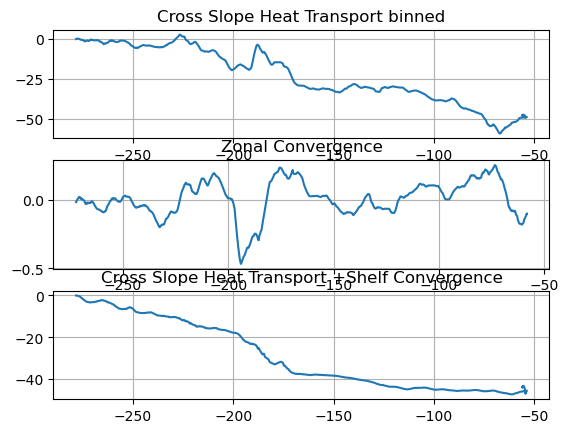

In [56]:
plt.subplot(3,1,1)

plt.plot(full_binned_lon,np.cumsum(Full_binned_transport)*0.08/1e12)
plt.grid(); plt.title('Cross Slope Heat Transport binned')

plt.subplot(3,1,2)
swin=50
plt.plot(running_mean(np.array(full_binned_lon),swin),
         running_mean(np.array(Shelf_convergence*0.08),swin)/1e12)
plt.grid(); plt.title('Zonal Convergence')

plt.subplot(3,1,3)
plt.plot(full_binned_lon,np.cumsum(Full_binned_transport+Shelf_convergence)*0.08/1e12)
plt.grid(); plt.title('Cross Slope Heat Transport +Shelf Convergence')




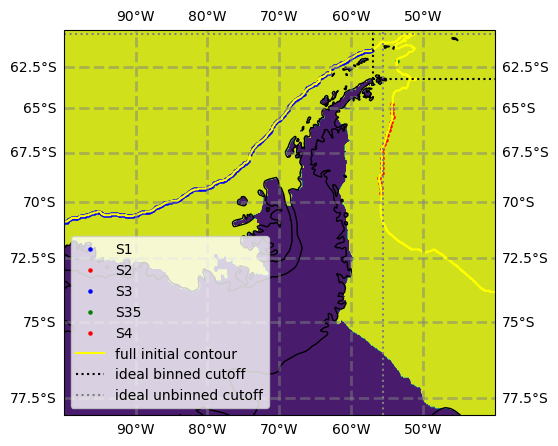

In [57]:
fig = plt.figure(figsize=(7, 5))
ax = plt.axes(projection=ccrs.Mercator(central_longitude=-60, min_latitude=-78, max_latitude=-60.0))

ax.set_extent([-100, -40, -78, -60], crs=ccrs.PlateCarree())
#ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])


#temp_xflux.plot(x='xu_ocean',y='yt_ocean',transform=ccrs.PlateCarree())
plt.contourf(temp_xflux.xu_ocean,temp_xflux.yt_ocean,lmask,transform=ccrs.PlateCarree(),zorder=0)

plt.scatter(S1_lon_bin_midpoints,S1_lat_bin_midpoints,transform=ccrs.PlateCarree(),c='blue',s=5,label='S1')
plt.scatter(S2_lon_bin_midpoints,S2_lat_bin_midpoints,transform=ccrs.PlateCarree(),c='red',s=5,label='S2')
plt.scatter(S3_lon_bin_midpoints,S3_lat_bin_midpoints,transform=ccrs.PlateCarree(),c='blue',s=5,label='S3')
plt.scatter(S35_lon_bin_midpoints,S35_lat_bin_midpoints,transform=ccrs.PlateCarree(),c='green',s=5,label='S35')
plt.scatter(S4_lon_bin_midpoints,S4_lat_bin_midpoints,transform=ccrs.PlateCarree(),c='red',s=5,label='S4')



plt.plot(lon_along_contour, lat_along_contour, 
        transform=ccrs.PlateCarree(),color='yellow',label='full initial contour',zorder=1)
#Ideal line:
plt.plot([-57,-57], [-63.25,-60], 
         transform=ccrs.PlateCarree(),color='black',linestyle=':',label='ideal binned cutoff')
plt.plot([-57,-40], [-63.25,-63.25], 
         transform=ccrs.PlateCarree(),color='black',linestyle=':')
plt.plot([-55.5,-55.5], [-78,-60], 
         transform=ccrs.PlateCarree(),color='gray',linestyle=':',label='ideal unbinned cutoff')
plt.plot([-100,-40], [-60.25,-60.25], 
         transform=ccrs.PlateCarree(),color='gray',linestyle=':')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
plt.legend()
ax.coastlines();



#### Section 5 binning (zonal binning)

In [58]:
	#Section 5, zonal binning
	S5_lon_coord = np.arange(S5_first_lon,S5_last_lon+lon_bin_spacing,lon_bin_spacing)   
	S5_lon_bin_midpoints = np.arange(S5_first_lon+lon_bin_width/2,S5_last_lon-lon_bin_width/2,lon_bin_spacing)
	S5_n_bin_edges = len(S5_lon_coord)
	
	# sum into longitude bins:
	# need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
	# on the isobath contour and sum continously along contour between defined indices.
	# (i.e. lon_along_contour is not monotonic)
	# find points on contour to define edges of longitude bins:
	bin_edge_indices = np.zeros(S5_n_bin_edges)
	for lon_bin in range(S5_n_bin_edges-1):
	    # find first isobath point that has the right longitude:
	    first_point = np.where(lon_along_contour[S4_ilim+1:]>=S5_lon_coord[lon_bin])[0][0]+S4_ilim+1
	    # then find all other isobath points with the same longitude as that first point:
	    same_lon_points = np.where(lon_along_contour[S4_ilim+1:]==lon_along_contour[first_point])[0]+S4_ilim+1
	    # we want the most southerly of these points on the same longitude line:
	    bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points])]
	#print('bin_edge_indices='+str(bin_edge_indices)+'\n\n')
	    
	# define east/west edges:
	bin_edge_indices = bin_edge_indices.astype(int)
	bin_edge_indices_west = bin_edge_indices[:-int(lon_bin_width/lon_bin_spacing)-1]
	bin_edge_indices_east = bin_edge_indices[int(lon_bin_width/lon_bin_spacing):-1]
	n_bins = len(bin_edge_indices_west)
	print('n_bins='+str(n_bins))
	
	# sum heat transport from isobath coord into new longitude coord:
	S5_cross_slope_heat_trans = np.zeros(n_bins)
	for lon_bin in range(n_bins):
	    S5_heat_trans_this_bin = heat_trans_across_contour[bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
	    S5_cross_slope_heat_trans[lon_bin] = np.sum(S5_heat_trans_this_bin)
	    
	# find average latitude of each bin, so we can plot back on the isobath:
	S5_lat_bin_midpoints = np.zeros(n_bins)
	for lon_bin in range(n_bins):
	    # find nearest isobath point:
	    S5_lon_index = np.where(lon_along_contour[S4_ilim+1:]>=S5_lon_bin_midpoints[lon_bin])[0][0]+S4_ilim+1
	    S5_lat_bin_midpoints[lon_bin] = lat_along_contour[S5_lon_index]
	
	

n_bins=530


Text(0, 0.5, 'latitude')

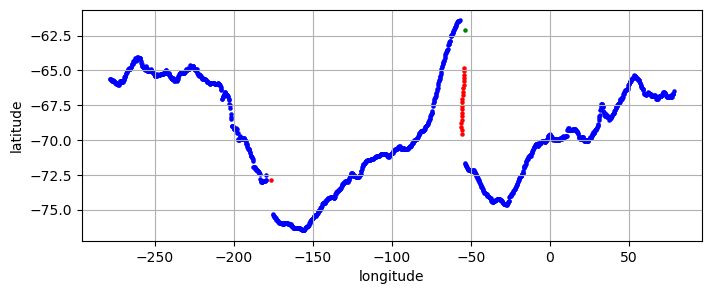

In [98]:
fig = plt.figure(figsize=(8,3))
plt.scatter(S1_lon_bin_midpoints,S1_lat_bin_midpoints,c='blue',s=5,label='S1')
plt.scatter(S2_lon_bin_midpoints,S2_lat_bin_midpoints,c='red',s=5,label='S2')
plt.scatter(S3_lon_bin_midpoints,S3_lat_bin_midpoints,c='blue',s=5,label='S3')
plt.scatter(S35_lon_bin_midpoints,S35_lat_bin_midpoints,c='green',s=5,label='S35')
plt.scatter(S4_lon_bin_midpoints,S4_lat_bin_midpoints,c='red',s=5,label='S4')
plt.scatter(S5_lon_bin_midpoints,S5_lat_bin_midpoints,c='blue',s=5,label='S5')
plt.grid()
plt.xlabel('longitude')
plt.ylabel('latitude')

In [60]:
	print('Calculating Zonal heat convergence for S5')
	# Need to make sure the zonal boundaries here match exactly with the zonal boundaries used for the 
	# longitude averaging above, by using same bin_edge_indices.
	# Just check if isobath point is on x or y grid. if x, sum up to this point from south.
	# if on y grid, sum zonal transport on nearest u grid point to west.
	
	zonal_heat_trans_west = np.zeros(n_bins)
	for lon_bin in range(n_bins):
	    # west limit:
	    # reset these to False:
	    on_x_grid = False
	    on_y_grid = False
	    # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
	    isobath_west_index = int(bin_edge_indices_west[lon_bin]+1)
	    # check if the point is on the x or y transport grid:
	    if len(np.where(mask_x_transport_numbered==isobath_west_index)[0])>0:
	        on_x_grid = True
	        jj = int(np.where(mask_x_transport_numbered==isobath_west_index)[0])
	        ii = int(np.where(mask_x_transport_numbered==isobath_west_index)[1])
	    elif len(np.where(mask_y_transport_numbered==isobath_west_index)[0])>0:
	        on_y_grid = True
	        jj = int(np.where(mask_y_transport_numbered==isobath_west_index)[0])
	        ii = int(np.where(mask_y_transport_numbered==isobath_west_index)[1])
	    if on_x_grid == True:
	        zonal_heat_trans_west[lon_bin] = np.sum(temp_xflux[:jj,ii]) 
	    # in this case we want transport half a grid point to the west:
	    elif on_y_grid == True:
	        # careful if ii=0, then we need heat trans from lon=80, because at limit of zonal grid
	        # if ii==0:
	        #     zonal_heat_trans_west[lon_bin] = np.sum(temp_xflux[:jj+1,ii-1])
	        # else:
	        zonal_heat_trans_west[lon_bin] = np.sum(temp_xflux[:jj+1,ii-1])
	
	zonal_heat_trans_east = np.zeros(n_bins)
	for lon_bin in range(n_bins):
	    # east limit:
	    # reset these to False:
	    on_x_grid = False
	    on_y_grid = False
	    # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
	    isobath_east_index = int(bin_edge_indices_east[lon_bin]+1)
	    # check if the point is on the x or y transport grid:
	    if len(np.where(mask_x_transport_numbered==isobath_east_index)[0])>0:
	        on_x_grid = True
	        jj = int(np.where(mask_x_transport_numbered==isobath_east_index)[0])
	        ii = int(np.where(mask_x_transport_numbered==isobath_east_index)[1])
	    elif len(np.where(mask_y_transport_numbered==isobath_east_index)[0])>0:
	        on_y_grid = True
	        jj = int(np.where(mask_y_transport_numbered==isobath_east_index)[0])
	        ii = int(np.where(mask_y_transport_numbered==isobath_east_index)[1])
	    if on_x_grid == True:
	        zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux[:jj,ii])
	    # in this case we want transport half a grid point to the west:
	    elif on_y_grid == True:
	        # wrap around to east side of grid:
	        # if ii==0:
	        #     zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux[:jj+1,-1])
	        # else:
	        zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux[:jj+1,ii-1])
	
	zonal_convergence = zonal_heat_trans_east - zonal_heat_trans_west

Calculating Zonal heat convergence for S5


In [61]:
Shelf_convergence = np.append(Shelf_convergence,zonal_convergence)
del zonal_heat_trans_east

In [62]:
full_binned_lon = np.append(np.append(np.append(np.append(np.append(S1_lon_bin_midpoints,S2_lon_bin_midpoints),S3_lon_bin_midpoints),S35_lon_bin_midpoints),S4_lon_bin_midpoints),S5_lon_bin_midpoints)
full_binned_lat = np.append(np.append(np.append(np.append(np.append(S1_lat_bin_midpoints,S2_lat_bin_midpoints),S3_lat_bin_midpoints),S35_lat_bin_midpoints),S4_lat_bin_midpoints),S5_lat_bin_midpoints)
Full_binned_transport = np.append(np.append(np.append(np.append(np.append(S1_cross_slope_heat_trans,S2_cross_slope_heat_trans),S3_cross_slope_heat_trans),S35_cross_slope_heat_trans),S4_cross_slope_heat_trans),S5_cross_slope_heat_trans)

In [244]:
factor_new0=np.sum(heat_trans_across_contour)/np.sum(Full_binned_transport+Shelf_convergence)
factor_new1=np.sum(heat_trans_across_contour)/np.sum(Full_binned_transport)
factor_new2=factor_new1/factor_new0

In [245]:
factor_new0,factor_new1,factor_new2

(0.08171035031521653, 0.07284236064128091, 0.8914704240071752)

Text(0.5, 1.0, 'Cross Slope Heat Transport +Shelf Convergence')

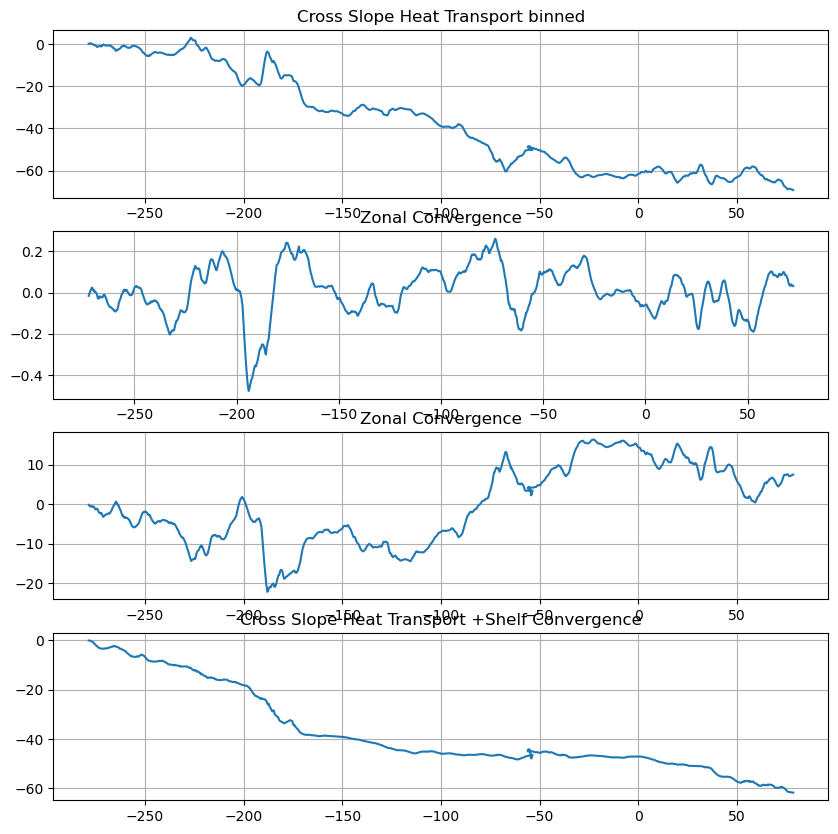

In [178]:
fig = plt.figure(figsize=(10,10))
plt.subplot(4,1,1)

plt.plot(full_binned_lon,np.cumsum(Full_binned_transport)*factor_new/1e12)
plt.grid(); plt.title('Cross Slope Heat Transport binned')

plt.subplot(4,1,2)
swin=50
plt.plot(running_mean(np.array(full_binned_lon),swin),
         running_mean(np.array(Shelf_convergence*factor_new),swin)/1e12)
plt.grid(); plt.title('Zonal Convergence')

plt.subplot(4,1,3)
swin=50
plt.plot(full_binned_lon,
         np.cumsum(np.array(Shelf_convergence))*factor_new/1e12)
plt.grid(); plt.title('Zonal Convergence')

plt.subplot(4,1,4)
plt.plot(full_binned_lon,np.cumsum(Full_binned_transport+Shelf_convergence)*factor_new/1e12)
plt.grid(); plt.title('Cross Slope Heat Transport +Shelf Convergence')





Comparrison with Adele's approach:

In [85]:
#Importing ADELE's heat transport for the same month
src = '/g/data/x77/wf4500/ASC_project/cross_slope_transport/Monthly/01deg_jra55v13_ryf9091/Ant_cross_slope_heat_terms_online_1000m_2095-01.nc'
HTz = xr.open_dataset(src)
#Dcross_slope_heat_trans= (HTz.cross_slope_heat_trans*factor) + (HTz.zonal_convergence*factor)
Ocross_slope_heat_trans= (HTz.cross_slope_heat_trans)
Oheat_trans_across_contour= (HTz.heat_trans_across_contour)
Ozonal_convergence = (HTz.zonal_convergence)

Adele_factor = np.nansum(HTz.heat_trans_across_contour)/np.nansum(HTz.cross_slope_heat_trans+HTz.zonal_convergence)

Adele_CCHTZC=(Ocross_slope_heat_trans + Ozonal_convergence)*Adele_factor
Adele_CCHT=(Ocross_slope_heat_trans)*Adele_factor
Adele_ZC=(Ozonal_convergence)*Adele_factor
ADELE_TOTAL_HT = np.sum(Adele_CCHTZC/1e12)

print('Total cross slope heat transport including solely zonal convergence ='+str(int(ADELE_TOTAL_HT))+' TW')

Total cross slope heat transport including solely zonal convergence =-61 TW


In [237]:
np.sum(Adele_ZC)/1e12

<xarray.DataArray 'zonal_convergence' ()>
array(0.51621299)

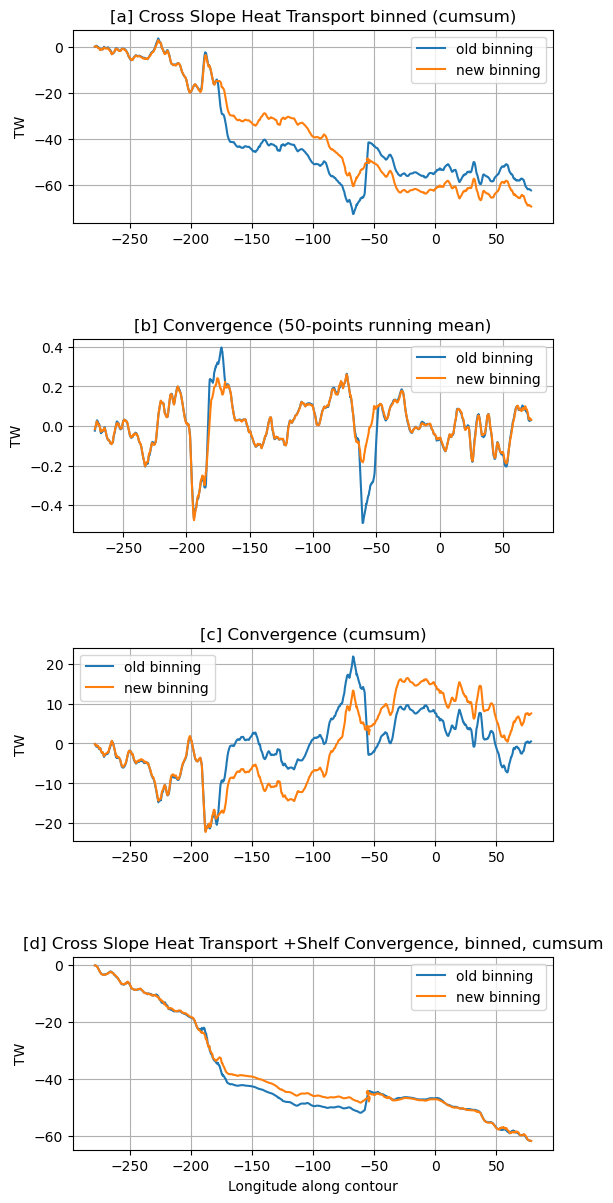

In [236]:
fig = plt.figure(figsize=(6,14))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.6)


plt.subplot(4,1,1)

plt.plot(Adele_CCHT.lon_bin_midpoints,np.cumsum(Adele_CCHT)/1e12,label='old binning')
plt.plot(full_binned_lon,np.cumsum(Full_binned_transport)*factor_new0/1e12,label='new binning')
plt.grid(); plt.title('[a] Cross Slope Heat Transport binned (cumsum)')
plt.legend()
plt.ylabel('TW')


plt.subplot(4,1,2)
swin=50
plt.plot(running_mean(np.array(Adele_CCHT.lon_bin_midpoints),swin),
         running_mean(np.array(Adele_ZC),swin)/1e12,label='old binning')

plt.plot(running_mean(np.array(full_binned_lon),swin),
         running_mean(np.array(Shelf_convergence*factor_new0),swin)/1e12,label='new binning')
plt.grid(); plt.title('[b] Convergence (50-points running mean)')
plt.ylabel('TW'); plt.legend()



plt.subplot(4,1,3)
plt.plot(Adele_CCHT.lon_bin_midpoints,
         np.cumsum(np.array(Adele_ZC))/1e12,label='old binning')
plt.plot(full_binned_lon,
         np.cumsum(np.array(Shelf_convergence*factor_new0))/1e12,label='new binning')
plt.grid(); plt.title('[c] Convergence (cumsum)')
plt.ylabel('TW'); plt.legend()



plt.subplot(4,1,4)
plt.plot(Adele_CCHT.lon_bin_midpoints,np.cumsum(Adele_CCHTZC)/1e12,label='old binning')
plt.plot(full_binned_lon,np.cumsum(Full_binned_transport+Shelf_convergence)*factor_new0/1e12,label='new binning')
plt.grid(); plt.title('[d] Cross Slope Heat Transport +Shelf Convergence, binned, cumsum')
plt.xlabel('Longitude along contour')
plt.ylabel('TW'); plt.legend()


plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/Convergenes_comparisson.png',dpi=300)

How do the contours differ?

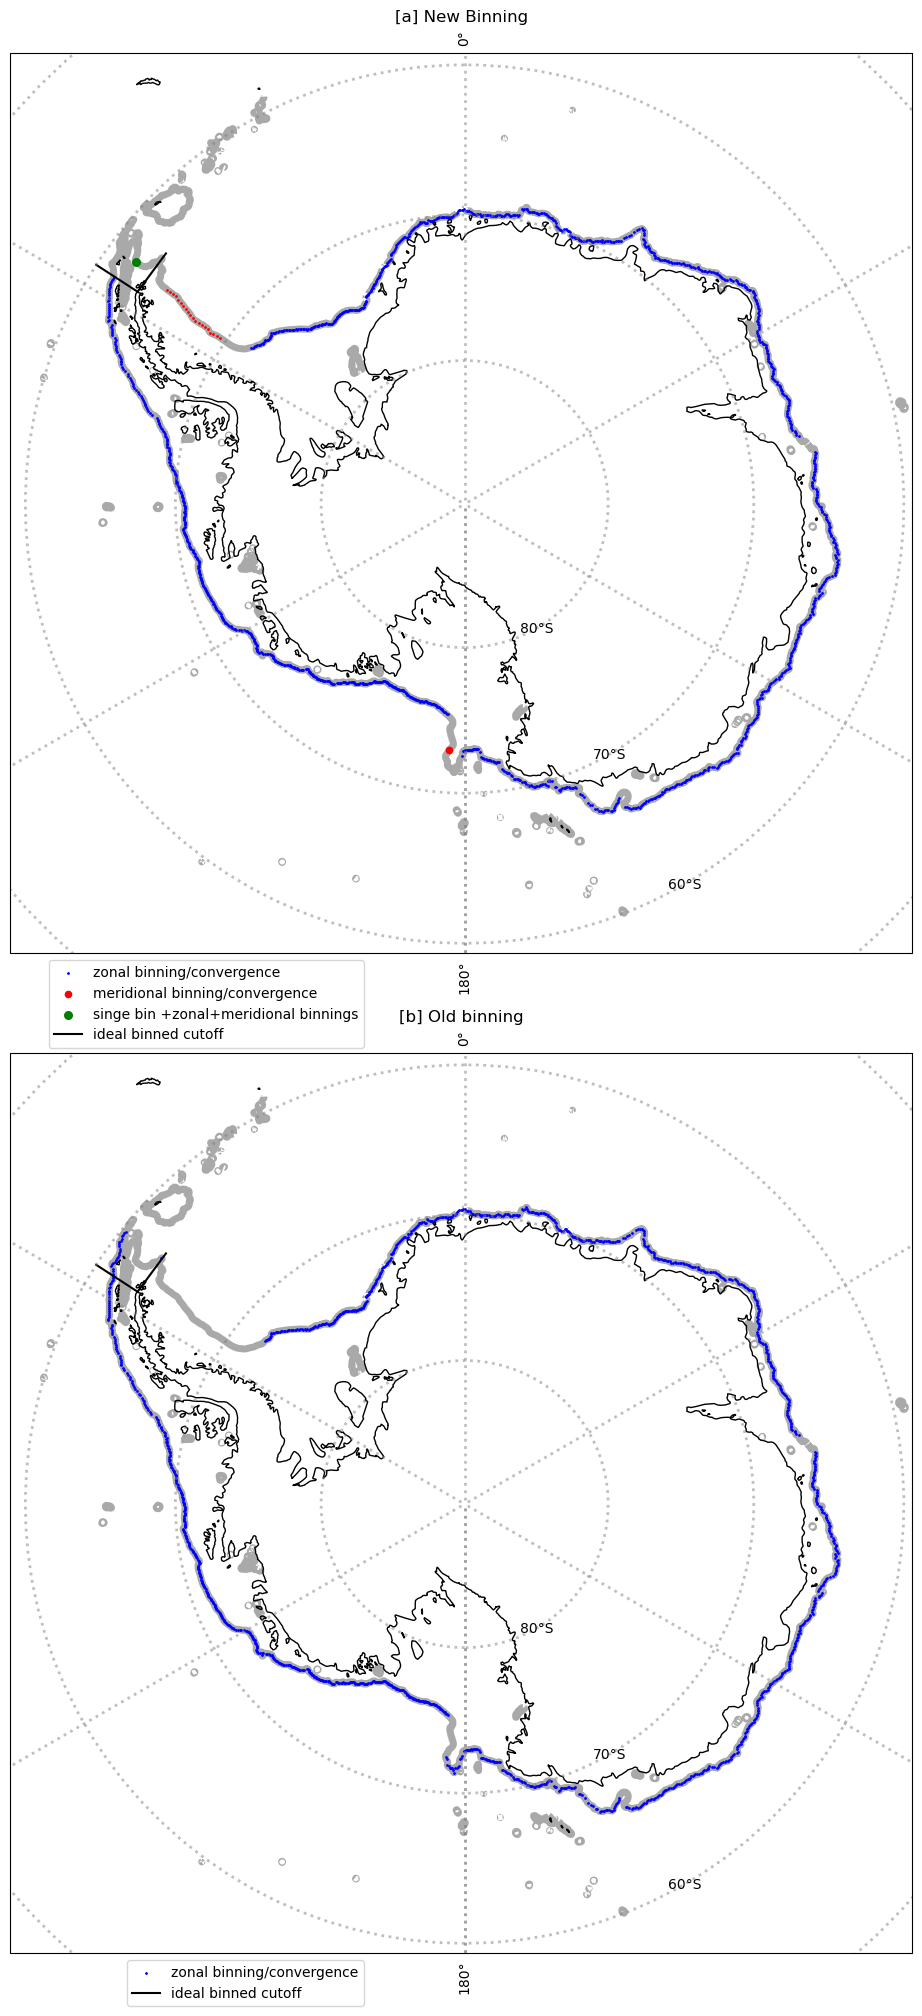

In [174]:
fig = plt.figure(figsize=(10,20))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.6)

projection=ccrs.SouthPolarStereo()


#top ploy
ax = plt.axes((0, 0.5, 1, 0.45),projection=projection)

ax.set_extent([-280, 80, -59, -78], crs=ccrs.PlateCarree())




plt.contour(temp_xflux.xu_ocean,temp_xflux.yt_ocean,ht,[1000],transform=ccrs.PlateCarree(),zorder=0,colors='darkgrey',linewidths=5,label='1000m isobath')


plt.scatter(S1_lon_bin_midpoints,S1_lat_bin_midpoints,c='blue',transform=ccrs.PlateCarree(),s=1,label='zonal binning/convergence')
plt.scatter(S2_lon_bin_midpoints,S2_lat_bin_midpoints,c='red',transform=ccrs.PlateCarree(),s=20,label='meridional binning/convergence')
plt.scatter(S3_lon_bin_midpoints,S3_lat_bin_midpoints,c='blue',transform=ccrs.PlateCarree(),s=1)
plt.scatter(S35_lon_bin_midpoints,S35_lat_bin_midpoints,c='green',transform=ccrs.PlateCarree(),s=30,label='singe bin +zonal+meridional binnings')
plt.scatter(S4_lon_bin_midpoints,S4_lat_bin_midpoints,c='red',transform=ccrs.PlateCarree(),s=1)
plt.scatter(S5_lon_bin_midpoints,S5_lat_bin_midpoints,c='blue',transform=ccrs.PlateCarree(),s=1)




plt.plot([-57,-57], [-63.25,-60], 
         transform=ccrs.PlateCarree(),color='black',label='ideal binned cutoff')
plt.plot([-57,-50], [-63.25,-63.25], 
         transform=ccrs.PlateCarree(),color='black')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle=':')
plt.legend(loc=1, bbox_to_anchor=(0.4,0))
ax.coastlines();
plt.title('[a] New Binning')



#bottom plot
ax1 = plt.axes((0, 0, 1, 0.45),projection=projection)
ax1.set_extent([-280, 80, -59, -78], crs=ccrs.PlateCarree())




plt.contour(temp_xflux.xu_ocean,temp_xflux.yt_ocean,ht,[1000],transform=ccrs.PlateCarree(),zorder=0,colors='darkgrey',linewidths=5,label='1000m isobath')


plt.scatter(HTz.lon_bin_midpoints,HTz.lat_bin_midpoints,c='blue',transform=ccrs.PlateCarree(),s=1,label='zonal binning/convergence')




#Ideal line:
plt.plot([-57,-57], [-63.25,-60], 
         transform=ccrs.PlateCarree(),color='black',label='ideal binned cutoff')
plt.plot([-57,-50], [-63.25,-63.25], 
         transform=ccrs.PlateCarree(),color='black')
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle=':')
plt.legend(loc=1, bbox_to_anchor=(0.4,0))
ax1.coastlines();
plt.title('[b] Old binning')
plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/binnings_comparisson.png',dpi=300)

Text(0.5, 1.0, 'Old binning')

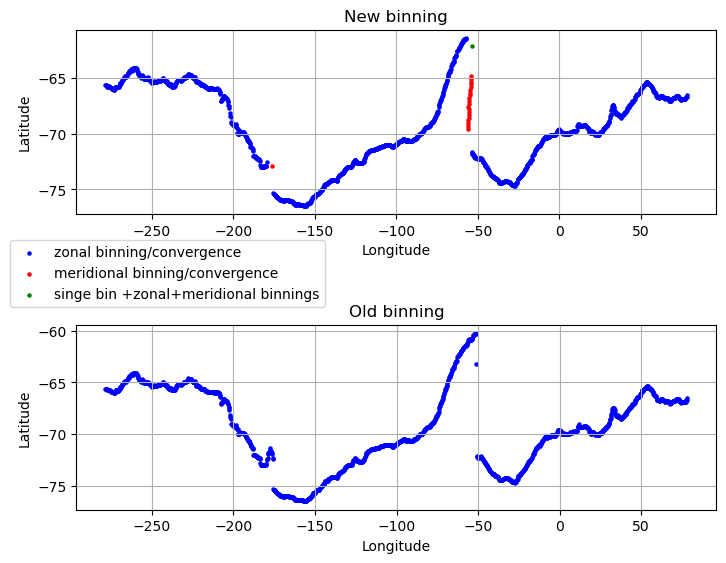

In [119]:
fig = plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.6)

plt.subplot(2,1,1)
plt.scatter(S1_lon_bin_midpoints,S1_lat_bin_midpoints,c='blue',s=5,label='zonal binning/convergence')
plt.scatter(S2_lon_bin_midpoints,S2_lat_bin_midpoints,c='red',s=5,label='meridional binning/convergence')
plt.scatter(S3_lon_bin_midpoints,S3_lat_bin_midpoints,c='blue',s=5)
plt.scatter(S35_lon_bin_midpoints,S35_lat_bin_midpoints,c='green',s=5,label='singe bin +zonal+meridional binnings')
plt.scatter(S4_lon_bin_midpoints,S4_lat_bin_midpoints,c='red',s=5)
plt.scatter(S5_lon_bin_midpoints,S5_lat_bin_midpoints,c='blue',s=5)
plt.grid()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc=1, bbox_to_anchor=(0.4,-0.1))
plt.title('New binning')


plt.subplot(2,1,2)
plt.scatter(HTz.lon_bin_midpoints,HTz.lat_bin_midpoints,c='blue',s=5,label='Previous Binning')
plt.grid()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Old binning')


## ANOTHER calculationisobath_north_index

The new coordinates will be:

In [ ]:
	# New idealized grid. this will be recalculated after, to make sure we match the edges of each cell
	full_dist_coord0 = np.arange(dist_min,dist_max+bin_spacing,bin_spacing)
	# the edges of each bin will be:
	first_edge = full_dist_coord0-bin_width # edges close to the beggining of the contour in -280
	last_edge = full_dist_coord0+bin_width  # edge close to the end of the contour in 80

Now we need to find which value in distance_along_contour are closest to the first and last edges. Those will be the true edges of each cell. This is procedure is required to make sure that the distance of ~140km match exactly where we have measurements of heat transport. Otherwise we would assume that the heat transport is located in teh edges of those distances contours, but they are not.

In [ ]:
#Representation
# X is the center of the bin
#|| are the edges of the bin

#-> direction of distance along contour ->
#             
#...----100km------------------X-------------------225km------   Distances[0 to 25000]km  
#...-----------|---------------X-----------------|------------  Location where we have HT along the contour
#...---------110km-------------X---------------205km----------   Corrected distance, on the location of HT

In [ ]:
	# sum into longitude bins:
	# need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
	# on the isobath contour and sum continously along contour between defined indices.
	# (i.e. lon_along_contour is not monotonic)
	# find points on contour to define edges of longitude bins:
	bin_edge_indices = np.zeros(n_bin_edges)
	for lon_bin in range(n_bin_edges-1):
	    # find first isobath point that has the right longitude:
	    first_point = np.where(lon_along_contour>=full_lon_coord[lon_bin])[0][0]
	    # then find all other isobath points with the same longitude as that first point:
	    same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
	    # we want the most southerly of these points on the same longitude line:
	    bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points])]
	    
	# define east/west edges:
	bin_edge_indices = bin_edge_indices.astype(int)
	bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
	bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
	n_bins = len(bin_edge_indices_west)
	
	# sum heat transport from isobath coord into new longitude coord:
	cross_slope_heat_trans = np.zeros(n_bins)
	for lon_bin in range(n_bins):
	    heat_trans_this_bin = heat_trans_across_contour[bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
	    cross_slope_heat_trans[lon_bin] = np.sum(heat_trans_this_bin)
	    
	# find average latitude of each bin, so we can plot back on the isobath:
	lat_bin_midpoints = np.zeros(n_bins)
	for lon_bin in range(n_bins):
	    # find nearest isobath point:
	    lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
	    lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]
	
	

In [ ]:
	temp_xflux=temp_xflux[0]
	temp_yflux=temp_yflux[0]
	
	print('Calculating Zonal heat convergence')
	# Need to make sure the zonal boundaries here match exactly with the zonal boundaries used for the 
	# longitude averaging above, by using same bin_edge_indices.
	# Just check if isobath point is on x or y grid. if x, sum up to this point from south.
	# if on y grid, sum zonal transport on nearest u grid point to west.
	
	zonal_heat_trans_west = np.zeros(n_bins)
	for lon_bin in range(n_bins):
	    # west limit:
	    # reset these to False:
	    on_x_grid = False
	    on_y_grid = False
	    # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
	    isobath_west_index = int(bin_edge_indices_west[lon_bin]+1)
	    # check if the point is on the x or y transport grid:
	    if len(np.where(mask_x_transport_numbered==isobath_west_index)[0])>0:
	        on_x_grid = True
	        jj = int(np.where(mask_x_transport_numbered==isobath_west_index)[0])
	        ii = int(np.where(mask_x_transport_numbered==isobath_west_index)[1])
	    elif len(np.where(mask_y_transport_numbered==isobath_west_index)[0])>0:
	        on_y_grid = True
	        jj = int(np.where(mask_y_transport_numbered==isobath_west_index)[0])
	        ii = int(np.where(mask_y_transport_numbered==isobath_west_index)[1])
	    if on_x_grid == True:
	        zonal_heat_trans_west[lon_bin] = np.sum(temp_xflux[:jj,ii])
	    # in this case we want transport half a grid point to the west:
	    elif on_y_grid == True:
	        # careful if ii=0, then we need heat trans from lon=80, because at limit of zonal grid
	        if ii==0:
	            zonal_heat_trans_west[lon_bin] = np.sum(temp_xflux[:jj+1,-1])
	        else:
	            zonal_heat_trans_west[lon_bin] = np.sum(temp_xflux[:jj+1,ii-1])
	
	zonal_heat_trans_east = np.zeros(n_bins)
	for lon_bin in range(n_bins):
	    # east limit:
	    # reset these to False:
	    on_x_grid = False
	    on_y_grid = False
	    # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
	    isobath_east_index = int(bin_edge_indices_east[lon_bin]+1)
	    # check if the point is on the x or y transport grid:
	    if len(np.where(mask_x_transport_numbered==isobath_east_index)[0])>0:
	        on_x_grid = True
	        jj = int(np.where(mask_x_transport_numbered==isobath_east_index)[0])
	        ii = int(np.where(mask_x_transport_numbered==isobath_east_index)[1])
	    elif len(np.where(mask_y_transport_numbered==isobath_east_index)[0])>0:
	        on_y_grid = True
	        jj = int(np.where(mask_y_transport_numbered==isobath_east_index)[0])
	        ii = int(np.where(mask_y_transport_numbered==isobath_east_index)[1])
	    if on_x_grid == True:
	        zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux[:jj,ii])
	    # in this case we want transport half a grid point to the west:
	    elif on_y_grid == True:
	        # wrap around to east side of grid:
	        if ii==0:
	            zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux[:jj+1,-1])
	        else:
	            zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux[:jj+1,ii-1])
	
	zonal_convergence = zonal_heat_trans_east - zonal_heat_trans_west
	